* [Algorithms](#algorithms)
    1. [LightGBM](#LightGBM)
    2. [XGBoost](#XGBoost)
    3. [LogisticRegression](#LogisticRegression)
    4. [RandomForest](#RandomForest)
    5. [DesicionTree](#DesicionTree)
    5. [Knn](#KNN)
    6. [NaiveBayes](#NaiveBayes)
    7. [GradientBoost](#GradientBoost)
    8. [Stochastic Gradient Descent Classifier](#StochasticGradientDescent)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import re
import datetime
import calendar
from functools import reduce
import datetime as dt
from itertools import chain
from pyspark.sql.functions import expr
from past.builtins import xrange
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import StructField, StringType, IntegerType, StructType, FloatType
from dateutil.relativedelta import relativedelta
from pyspark.sql.functions import udf
from pyspark.sql.functions import mean, min, max
import subprocess
import math
from time import time
import dateutil.relativedelta as dr
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.session import SparkSession
from pyspark.conf import SparkConf

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import shap
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV
#from sklearn.externals import joblib

In [4]:
#from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.ensemble import BalancedBaggingClassifier

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [6]:
# Get spark
config = SparkConf().setAll([
        ('spark.driver.port', '59600'),
        ('spark.blockManager.port', '59601'),
        ('spark.broadcast.port', '59602'),
        ('spark.replClassServer', '59603'),
        ('spark.ui.port', '59604'),
        ('spark.executor.port', '59605'),
        ('spark.fileserver.port', '59606'),
        ('spark.yarn.executor.memoryOverhead', 4096),
        ('spark.yarn.driver.memoryOverhead', 6144)#,
    #('spark.sql.session.timeZone','EET')
    ])

spark = SparkSession.builder.config(conf=config).getOrCreate()

# FUNCTIONS

In [7]:
# Read data from a specific month,year

def read_in_data(in_file, year = None, month = None):
    df = spark.read.parquet(in_file.format(year, month))
    return df

In [8]:
# Read data from a specific day,month,year

def read_in_data2(in_file, year = None, month = None, day = None):
    df = spark.read.parquet(in_file.format(year, month, day))
    return df

In [9]:
def downsampling(dataset, n_majority):
    dataset_major = dataset[(dataset['HIGHER_BUNDLE'] == 0)]
    dataset_minor = dataset[(dataset['HIGHER_BUNDLE'] == 1)]
    major = dataset_major.sample(n=n_majority, random_state=10) #downsampling
    df_sampled = pd.concat([major, dataset_minor])
    df_shuffled = df_sampled.sample(frac=1)
    
    return df_shuffled

In [10]:
def stratified_sampling(dataset, n_majority):
    dataset_major = dataset[(dataset['HIGHER_BUNDLE'] == 0)]
    dataset_minor = dataset[(dataset['HIGHER_BUNDLE'] == 1)]
    major = dataset_major.groupby('TARIFF_PLAN', group_keys=False).apply(lambda x: x.sample(n_majority,replace=True))
    df_sampled = pd.concat([major, dataset_minor])
    df_shuffled = df_sampled.sample(frac=1)
    
    return df_shuffled

In [11]:
def split_x_y(df):
    X = df.drop(["MSISDN","HIGHER_BUNDLE"], axis=1)
    y = df["HIGHER_BUNDLE"].values
    
    return X,y

In [12]:
def encoding_data(X, y):
    le = LabelEncoder()
    objects = X.select_dtypes(include=['object'])
    object_names = list(objects.columns.values)
    
    # Encoding all the categorical columns
    for object_name in object_names:
        if (X[object_name].nunique() > 2):
            enc_pc = pd.get_dummies(X[object_name], drop_first = True)
            X = X.drop(object_name, axis = 1)
            X = pd.concat([X,enc_pc], axis = 1)
        elif (X[object_name].nunique() <= 2):
            le.fit(X[object_name].astype(str))
            X[object_name] = le.transform(X[object_name].astype(str))


    y = le.fit_transform(y)
    
    return X,y

In [13]:
def estimate_proportion(y):
    count_train_0= (y == 0).sum()
    count_train_1= (y == 1).sum()
    
    proportion = float(float(count_train_0) / float(count_train_1))
    
    return proportion

In [14]:
def split_train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
    
    return X_train, X_test, y_train, y_test

In [15]:
def split_train_test_2(df):
    df_train, df_test = train_test_split(df, test_size = 0.25, random_state = 1)
    
    return df_train, df_test

In [16]:
def evaluation(X_test, y_test, classifier):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    target_names = ['No higher bundle', 'Higher Bundle']
    evaluation_report = classification_report(y_test, y_pred, target_names=target_names)
    
    return cm, accuracy, evaluation_report

In [17]:
def evaluation2(X_test, y_test, classifier, labels):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    evaluation_report = classification_report(y_test, y_pred, target_names=labels)
    
    return cm, accuracy, evaluation_report

In [18]:
def evaluation3(X_test, y_test, classifier):
    y_pred = classifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1 
    y_pred[y_pred < 0.5] = 0
    
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    target_names = ['No higher bundle', 'Higher Bundle']
    evaluation_report = classification_report(y_test, y_pred, target_names=target_names)
    
    return cm, accuracy, evaluation_report

In [19]:
def feature_importance(X_test, classifier):
    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(X_test)
    
    return shap_values

In [16]:
# def up_down_sampling(X, y, up_proportion, down_proportion):
#     # PIPELINE
#     # upsampling
#     over = SMOTE(up_proportion) # , k_neighbors=neighbors
#     # downsampling
#     under = RandomUnderSampler(down_proportion)
#     #under = TomekLinks(ratio=down_proportion)
#     steps = [('o', over), ('u', under)]
#     pipeline = Pipeline(steps=steps)
#     X_resampled, y_resampled = pipeline.fit_resample(X, y)
    
#     return X_resampled, y_resampled

# DATASET OVERVIEW

In [20]:
features = ['MSISDN', 'M1_TTL_OUT_CALLS', 'M1_V_CALLS_TO_COMPETITION', 'M1_V_MINUTES_TO_COMPETITION', 
          'M1_GPRS_SESSION', 'M1_GPRS_VOLUME', 'M1_RECHARGES_VALUE', 'M1_OUT_DAYS', 'M1_INC_DAYS', 
          'M1_BUNDLE_REVENUE', 'M2_RECHARGES_VALUE', 'M2_OUT_DAYS', 'M2_INC_DAYS', 'M2_BUNDLE_REVENUE', 
          'M3_V_CALLS_TO_COMPETITION', 'M3_GPRS_VOLUME', 'M3_BUNDLE_REVENUE', 'M4_GPRS_VOLUME', 'M4_INC_DAYS', 
          'M4_BUNDLE_REVENUE', 'M5_V_MINUTES_TO_COMPETITION', 'M5_BUNDLE_REVENUE', 'M6_V_MINUTES_TO_COMPETITION',
          'M6_BUNDLE_REVENUE', 'M1_ARPU', 'M2_ARPU', 'M4_ARPU', 'M5_ARPU', 'M1_ROC_TTL_OUT_CALLS',
          'M13_AVG_TTL_OUT_CALLS', 'M13_AVG_TTL_OUT_MINUTES', 'M13_AVG_V_CALLS_TO_COMPETITION',
          'M13_AVG_V_MINUTES_TO_COMPETITION', 'M13_AVG_GPRS_VOLUME', 'M16_AVG_GPRS_VOLUME', 
          'M13_AVG_RECHARGES_VALUE', 'M46_AVG_RECHARGES_VALUE', 'M16_AVG_RECHARGES_VALUE', 'M13_AVG_OUT_DAYS',
          'M16_AVG_OUT_DAYS', 'M13_AVG_INC_DAYS', 'M16_AVG_INC_DAYS', 'M13_AVG_BUNDLE_REVENUE',
          'M46_AVG_BUNDLE_REVENUE', 'M16_AVG_BUNDLE_REVENUE', 'M1_EXPENDITURE_RATIO', 'M2_EXPENDITURE_RATIO', 
          'STUDENTS_FLAG', 'VOICE_BUCKET_SUMMARY', 'DATA_BUCKET_SUMMARY', 'SMS_BUCKET_SUMMARY', 'BALANCE', 
          'DIGITAL', 'TARIFF_PLAN' ,'M1_TTL_OUT_MINUTES', 'M2_RECHARGES_NUMBER', 'M3_ARPU', 'M1_ROC_V_CALLS_TO_COMPETITION',
          'M16_AVG_TTL_OUT_CALLS', 'M13_AVG_RECHARGES_NUMBER', 'M46_AVG_INC_DAYS', 'M13_AVG_ARPU', 'M46_AVG_ARPU', 'HIGHER_BUNDLE']

In [21]:
pyspark_df_train = spark.read.parquet('gs://vf-gr-ca-nonlive-devds/irida/df/tariff_all/may/parquet/2.0/year=2022/month=5/day=1').select(features)
pyspark_df_test = spark.read.parquet('gs://vf-gr-ca-nonlive-devds/irida/df/tariff_all/june/parquet/2.0/year=2022/month=6/day=1').select(features)
#pyspark_df_test2 = spark.read.parquet('gs://vf-gr-ca-nonlive-devds/irida/df/tariff_all/july/parquet/2.0/year=2022/month=7/day=1').select(features)

In [20]:
#pyspark_df_train = spark.read.parquet('gs://vf-gr-ca-nonlive-devds/irida/df/tariff_all/june/parquet/2.0/year=2022/month=6/day=1').select(features)
#pyspark_df_test = spark.read.parquet('gs://vf-gr-ca-nonlive-devds/irida/df/tariff_all/july/parquet/2.0/year=2022/month=7/day=1').select(features)

In [23]:
#pyspark_df_train.printSchema()

root
 |-- M1_TTL_OUT_CALLS: double (nullable = true)
 |-- M1_V_CALLS_TO_COMPETITION: double (nullable = true)
 |-- M1_V_MINUTES_TO_COMPETITION: double (nullable = true)
 |-- M1_GPRS_SESSION: double (nullable = true)
 |-- M1_GPRS_VOLUME: double (nullable = true)
 |-- M1_RECHARGES_VALUE: double (nullable = true)
 |-- M1_OUT_DAYS: double (nullable = true)
 |-- M1_INC_DAYS: double (nullable = true)
 |-- M1_BUNDLE_REVENUE: double (nullable = true)
 |-- M2_RECHARGES_VALUE: double (nullable = true)
 |-- M2_OUT_DAYS: double (nullable = true)
 |-- M2_INC_DAYS: double (nullable = true)
 |-- M2_BUNDLE_REVENUE: double (nullable = true)
 |-- M3_V_CALLS_TO_COMPETITION: double (nullable = true)
 |-- M3_GPRS_VOLUME: double (nullable = true)
 |-- M3_BUNDLE_REVENUE: double (nullable = true)
 |-- M4_GPRS_VOLUME: double (nullable = true)
 |-- M4_INC_DAYS: double (nullable = true)
 |-- M4_BUNDLE_REVENUE: double (nullable = true)
 |-- M5_V_MINUTES_TO_COMPETITION: double (nullable = true)
 |-- M5_BUNDLE_REVE

In [85]:
#print((pyspark_df_train.count(), len(pyspark_df_train.columns)))
#print((pyspark_df_test.count(), len(pyspark_df_test.columns)))

(1378713, 64)
(1360022, 64)


In [21]:
#pyspark_df_test.printSchema()

In [62]:
#pyspark_df_train.limit(5).toPandas()

,MSISDN,M1_TTL_OUT_CALLS,M1_V_CALLS_TO_COMPETITION,M1_V_MINUTES_TO_COMPETITION,M1_GPRS_SESSION,M1_GPRS_VOLUME,M1_RECHARGES_VALUE,M1_OUT_DAYS,M1_INC_DAYS,M1_BUNDLE_REVENUE,M2_RECHARGES_VALUE,M2_OUT_DAYS,M2_INC_DAYS,M2_BUNDLE_REVENUE,M3_V_CALLS_TO_COMPETITION,M3_GPRS_VOLUME,M3_BUNDLE_REVENUE,M4_GPRS_VOLUME,M4_INC_DAYS,M4_BUNDLE_REVENUE,M5_V_MINUTES_TO_COMPETITION,M5_BUNDLE_REVENUE,M6_V_MINUTES_TO_COMPETITION,M6_BUNDLE_REVENUE,M1_ARPU,M2_ARPU,M4_ARPU,M5_ARPU,M1_ROC_TTL_OUT_CALLS,M13_AVG_TTL_OUT_CALLS,M13_AVG_TTL_OUT_MINUTES,M13_AVG_V_CALLS_TO_COMPETITION,M13_AVG_V_MINUTES_TO_COMPETITION,M13_AVG_GPRS_VOLUME,M16_AVG_GPRS_VOLUME,M13_AVG_RECHARGES_VALUE,M46_AVG_RECHARGES_VALUE,M16_AVG_RECHARGES_VALUE,M13_AVG_OUT_DAYS,M16_AVG_OUT_DAYS,M13_AVG_INC_DAYS,M16_AVG_INC_DAYS,M13_AVG_BUNDLE_REVENUE,M46_AVG_BUNDLE_REVENUE,M16_AVG_BUNDLE_REVENUE,M1_EXPENDITURE_RATIO,M2_EXPENDITURE_RATIO,STUDENTS_FLAG,VOICE_BUCKET_SUMMARY,DATA_BUCKET_SUMMARY,SMS_BUCKET_SUMMARY,BALANCE,DIGITAL,TARIFF_PLAN,M1_TTL_OUT_MINUTES,M2_RECHARGES_NUMBER,M3_ARPU,M1_ROC_V_CALLS_TO_COMPETITION,M16_AVG_TTL_OUT_CALLS,M13_AVG_RECHARGES_NUMBER,M46_AVG_INC_DAYS,M13_AVG_ARPU,M46_AVG_ARPU,HIGHER_BUNDLE
0,6900052362,17.0,0.0,0.000000,132.0,324.911324,10.91,12.0,16.0,12.0,10.91,2.0,14.0,12.0,0.0,617.450156,10.0,597.677805,13.0,10.0,0.000000,10.0,0.00,10.0,12.00,12.0,10.0000,10.00,41.500000,6.000000,0.800000,0.000000,0.000000,314.358775,358.705381,10.910000,10.843333,10.876667,5.000000,2.666667,17.000000,13.833333,11.333333,10.000000,10.666667,0.909167,0.909167,N,0.0,0.0,0.0,0.0,0,VFPP,0.000000,1.0,10.0000,0.000000,3.166667,1.000000,10.666667,11.333333,10.826667,0
1,6900081389,1.0,1.0,0.166667,4131.0,630.604492,0.00,1.0,3.0,0.0,0.00,6.0,4.0,0.0,0.0,267.635742,10.0,111.524414,3.0,0.0,0.150000,0.0,11.20,0.0,0.81,0.0,0.0000,0.00,-0.642857,0.333333,0.055556,0.333333,0.055556,299.414062,214.950521,3.636667,0.000000,1.818333,2.333333,2.500000,2.666667,4.000000,3.333333,0.000000,1.666667,0.000000,0.000000,N,0.0,0.0,0.0,0.0,0,CU,0.166667,0.0,10.0000,0.666667,2.500000,0.333333,5.333333,3.603333,0.000000,0
2,6900096144,48.0,0.0,0.000000,0.0,0.000000,0.00,23.0,8.0,0.0,0.00,18.0,21.0,0.0,0.0,0.000000,0.0,0.000000,21.0,10.0,0.000000,0.0,0.00,0.0,0.00,0.0,10.0000,0.00,1.051282,24.333333,12.972222,0.000000,0.000000,0.000000,0.000000,0.000000,3.636667,1.818333,19.000000,18.000000,17.666667,20.333333,0.000000,3.333333,1.666667,0.000000,0.000000,N,0.0,0.0,0.0,0.0,0,CU,26.866667,0.0,0.8100,-1.000000,27.500000,0.000000,23.000000,0.270000,3.333333,0
3,6900098600,45.0,15.0,22.250000,236.0,6071.104522,10.91,18.0,29.0,8.5,10.91,15.0,25.0,2.5,18.0,4531.026531,8.5,2646.121094,21.0,8.5,3.050000,0.0,3.25,0.0,8.50,2.5,8.5000,0.00,0.785714,44.333333,117.172222,13.666667,25.522222,3692.331770,3399.237500,10.910000,3.636667,7.273333,16.666667,10.666667,25.333333,24.666667,6.500000,2.833333,4.666667,1.283529,4.364000,Y,0.0,0.0,0.0,0.0,0,CU,85.083333,1.0,11.0032,1.272727,28.500000,1.000000,24.000000,7.334400,2.833333,1
4,6900121096,67.0,53.0,37.066667,13.0,469.103516,10.91,27.0,27.0,6.0,10.91,23.0,24.0,6.0,93.0,142.695312,6.0,365.525391,26.0,6.0,61.516667,0.0,58.90,6.0,9.24,6.0,6.2944,2.43,-0.061625,59.666667,54.027778,50.333333,39.605556,203.932943,250.160482,10.910000,7.206667,9.058333,25.000000,25.500000,27.000000,26.666667,6.000000,4.000000,5.000000,1.818333,1.818333,N,0.0,0.0,0.0,0.0,0,INTERNATIONAL,59.866667,1.0,13.0688,-0.089347,70.666667,1.000000,26.333333,9.436267,5.914400,0


In [22]:
# Convert to Pandas
df_train = pyspark_df_train.toPandas()
df_test = pyspark_df_test.toPandas()

In [82]:
#df_train.head()

,MSISDN,M1_TTL_OUT_CALLS,M1_V_CALLS_TO_COMPETITION,M1_V_MINUTES_TO_COMPETITION,M1_GPRS_SESSION,M1_GPRS_VOLUME,M1_RECHARGES_VALUE,M1_OUT_DAYS,M1_INC_DAYS,M1_BUNDLE_REVENUE,M2_RECHARGES_VALUE,M2_OUT_DAYS,M2_INC_DAYS,M2_BUNDLE_REVENUE,M3_V_CALLS_TO_COMPETITION,M3_GPRS_VOLUME,M3_BUNDLE_REVENUE,M4_GPRS_VOLUME,M4_INC_DAYS,M4_BUNDLE_REVENUE,M5_V_MINUTES_TO_COMPETITION,M5_BUNDLE_REVENUE,M6_V_MINUTES_TO_COMPETITION,M6_BUNDLE_REVENUE,M1_ARPU,M2_ARPU,M4_ARPU,M5_ARPU,M1_ROC_TTL_OUT_CALLS,M13_AVG_TTL_OUT_CALLS,M13_AVG_TTL_OUT_MINUTES,M13_AVG_V_CALLS_TO_COMPETITION,M13_AVG_V_MINUTES_TO_COMPETITION,M13_AVG_GPRS_VOLUME,M16_AVG_GPRS_VOLUME,M13_AVG_RECHARGES_VALUE,M46_AVG_RECHARGES_VALUE,M16_AVG_RECHARGES_VALUE,M13_AVG_OUT_DAYS,M16_AVG_OUT_DAYS,M13_AVG_INC_DAYS,M16_AVG_INC_DAYS,M13_AVG_BUNDLE_REVENUE,M46_AVG_BUNDLE_REVENUE,M16_AVG_BUNDLE_REVENUE,M1_EXPENDITURE_RATIO,M2_EXPENDITURE_RATIO,STUDENTS_FLAG,VOICE_BUCKET_SUMMARY,DATA_BUCKET_SUMMARY,SMS_BUCKET_SUMMARY,BALANCE,DIGITAL,TARIFF_PLAN,M1_TTL_OUT_MINUTES,M2_RECHARGES_NUMBER,M3_ARPU,M1_ROC_V_CALLS_TO_COMPETITION,M16_AVG_TTL_OUT_CALLS,M13_AVG_RECHARGES_NUMBER,M46_AVG_INC_DAYS,M13_AVG_ARPU,M46_AVG_ARPU,HIGHER_BUNDLE,CU,INTERNATIONAL,TAZA,VFPP
0,6903565312,1.0,0.0,0.000000,14.0,612.000000,0.00,1.0,15.0,0.0,10.91,0.0,12.0,10.0,6.0,399.998047,0.0,0.002930,12.0,10.0,7.950000,10.0,6.533333,10.0,0.0,10.0,10.7,10.8100,-0.963504,10.666667,28.722222,2.000000,0.927778,337.332682,215.943599,3.636667,10.843333,7.240000,5.333333,11.166667,11.666667,12.666667,3.333333,10.000000,6.666667,0.000,1.091000,N,0.0,0.0,0.0,0.00,0,CU,3.533333,1.0,1.2900,-1.000000,23.000000,0.333333,13.666667,3.763333,10.736667,0,1,0,0,0
1,6904541738,127.0,25.0,21.783333,88.0,547.135673,27.27,27.0,27.0,10.0,18.18,23.0,22.0,10.0,29.0,344.200839,0.0,931.444336,22.0,10.0,0.650000,10.0,0.000000,0.0,10.0,10.0,10.0,10.7744,1.442308,82.666667,51.244444,18.000000,17.755556,297.112171,306.473566,15.150000,7.273333,11.211667,25.333333,17.833333,24.000000,18.500000,6.666667,6.666667,6.666667,2.727,1.818000,N,0.0,0.0,0.0,0.00,0,CU,71.733333,1.0,0.2944,1.604167,64.500000,0.666667,13.000000,6.764800,6.924800,0,1,0,0,0
2,6907391917,0.0,0.0,0.000000,28.0,1392.623182,0.00,0.0,10.0,0.0,11.82,1.0,7.0,10.5,0.0,2405.540189,0.0,0.000000,3.0,10.5,0.000000,0.0,0.000000,0.0,0.0,10.5,10.5,0.0000,-1.000000,1.333333,0.000000,0.000000,0.000000,1266.054457,714.168066,3.940000,3.940000,3.940000,1.000000,0.666667,6.666667,5.333333,3.500000,3.500000,3.500000,0.000,1.125714,N,0.0,0.0,0.0,0.00,0,INTERNATIONAL,0.000000,1.0,1.1776,0.000000,0.833333,0.333333,4.000000,3.892533,3.500000,0,0,1,0,0
3,6908662876,14.0,4.0,3.833333,86.0,2412.965632,0.00,9.0,20.0,6.0,10.91,0.0,11.0,0.0,3.0,2308.613281,0.0,3321.968750,9.0,6.0,3.733333,3.0,0.000000,0.0,10.0,0.0,6.0,3.0000,0.428571,6.000000,4.233333,2.333333,1.827778,1573.859638,1726.013641,3.636667,3.636667,3.636667,4.000000,5.666667,14.666667,10.500000,2.000000,3.000000,2.500000,0.000,0.000000,N,0.0,0.0,0.0,0.00,0,INTERNATIONAL,10.716667,1.0,0.0000,-0.047619,10.500000,0.333333,6.333333,3.333333,3.000000,0,0,1,0,0
4,6909503748,223.0,146.0,216.033333,0.0,0.000000,10.91,31.0,26.0,10.0,10.91,30.0,22.0,10.0,146.0,0.000000,10.0,0.000000,19.0,10.0,109.216667,10.0,145.800000,10.0,10.0,10.0,10.0,10.0000,0.324228,152.333333,222.838889,98.333333,143.877778,0.000000,0.000000,10.910000,10.843333,10.876667,30.666667,29.833333,24.333333,24.166667,10.000000,10.000000,10.000000,1.091,1.091000,N,780.0,1800.0,300.0,6.46,0,VFPP,312.866667,1.0,10.0000,0.563169,177.500000,1.000000,24.000000,10.000000,10.000000,0,0,0,0,1


In [22]:
df_train["TARIFF_PLAN"].value_counts()

CU               1001898
VFPP              183444
TAZA               93928
INTERNATIONAL      80752
Name: TARIFF_PLAN, dtype: int64

In [ ]:
#df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001898 entries, 0 to 1001897
Columns: 258 entries, MSISDN to HIGHER_BUNDLE
dtypes: datetime64[ns](2), float64(235), int32(2), int64(12), object(7)
memory usage: 1.9+ GB


In [23]:
df_train["HIGHER_BUNDLE"].value_counts()    # df.groupBy("HIGHER_BUNDLE").count().show()

0    1323485
1      36537
Name: HIGHER_BUNDLE, dtype: int64

In [24]:
df_test["HIGHER_BUNDLE"].value_counts()    # df.groupBy("HIGHER_BUNDLE").count().show()

0    1329344
1      30275
Name: HIGHER_BUNDLE, dtype: int64

# PREPROCESSING

In [23]:
# TRAIN
#Downsampling
df_train_sampled = downsampling(df_train, n_majority= 100000)  # change this number
# Define X and y
X_previous_train, y_previous_train = split_x_y(df_train_sampled)
# Encoding
X_previous_train, y_previous_train = encoding_data(X_previous_train, y_previous_train)
# Save feature name
feature_names= np.array(X_previous_train.columns)

In [55]:
# Define X and y
# X_previous_train, y_previous_train = split_x_y(df_train)
# # Encoding
# X_previous_train, y_previous_train = encoding_data(X_previous_train, y_previous_train)
# # Save feature name
# feature_names= np.array(X_previous_train.columns)
# # Sampling
# X_previous_train_resampled, y_previous_train_resampled = up_down_sampling(X_previous_train, y_previous_train, up_proportion={1: 70000}, down_proportion={0: 100000}) 

In [24]:
# TEST
# Define X and y
X_previous_test, y_previous_test = split_x_y(df_test)
# Encoding
X_previous_test, y_previous_test = encoding_data(X_previous_test, y_previous_test)
# Save feature name
feature_names= np.array(X_previous_test.columns)

In [25]:
previous_proportion = estimate_proportion(y_previous_train)
print(previous_proportion)

3.284287966368891


In [ ]:
#int(previous_proportion)

2

In [26]:
X_previous_train_new = X_previous_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#X_previous_test_new = X_previous_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

### LightGBM

In [27]:
lgbm = lgb.LGBMClassifier(boosting_type = 'gbdt',
                                    importance_type = 'gain',
                                    scale_pos_weight= 3,
                                    n_estimators = 1000,
                                    learning_rate=0.01, metric='auc', silent=True, n_jobs=-1, random_state=10)

In [28]:
lgbm.fit(X_previous_train_new, y_previous_train)

LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

In [31]:
# JULY
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, lgbm)
print(cm)
print(acc)
print(class_report)

[[909886 419458]
 [  5701  24574]]
0.6872954849851318
                  precision    recall  f1-score   support

No higher bundle       0.99      0.68      0.81   1329344
   Higher Bundle       0.06      0.81      0.10     30275

        accuracy                           0.69   1359619
       macro avg       0.52      0.75      0.46   1359619
    weighted avg       0.97      0.69      0.79   1359619



In [32]:
print("!")

!


In [29]:
# JUNE
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, lgbm)
print(cm)
print(acc)
print(class_report)

[[949650 373835]
 [  8153  28384]]
0.7191310140571255
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.78      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.75      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



In [30]:
# ESTIMATE HOW MANY CUSTOMERS THE MODEL PREDICTED THAT WILL BUY THE HIGHER BUNDLE
pred_y_propab = lgbm.predict_proba(X_previous_test)
pred_y_propab[:,1]
condition = pred_y_propab[:,1] >= 0.5
len(pred_y_propab[:,1][condition])

array([0.41859182, 0.5174942 , 0.77569405, ..., 0.05931196, 0.45696365,
       0.10963786])

402219

In [ ]:
shap_values = feature_importance(X_previous_test, lgbm)

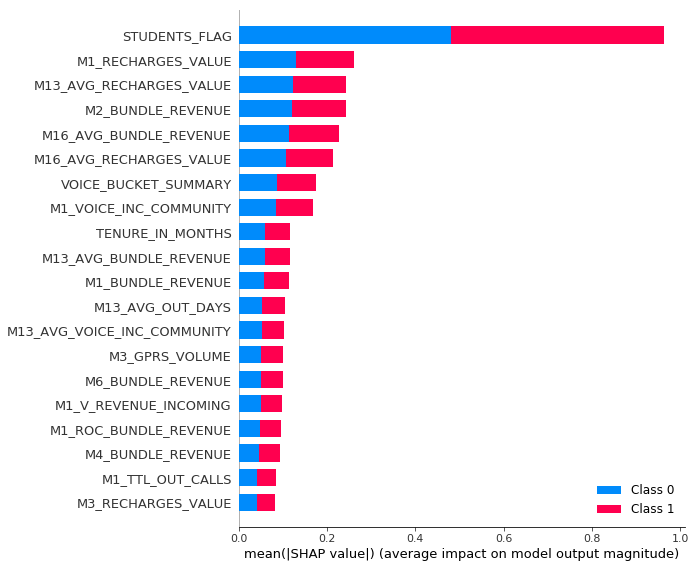

In [ ]:
#shap.summary_plot(shap_values, X_previous_test, feature_names, plot_type="bar")

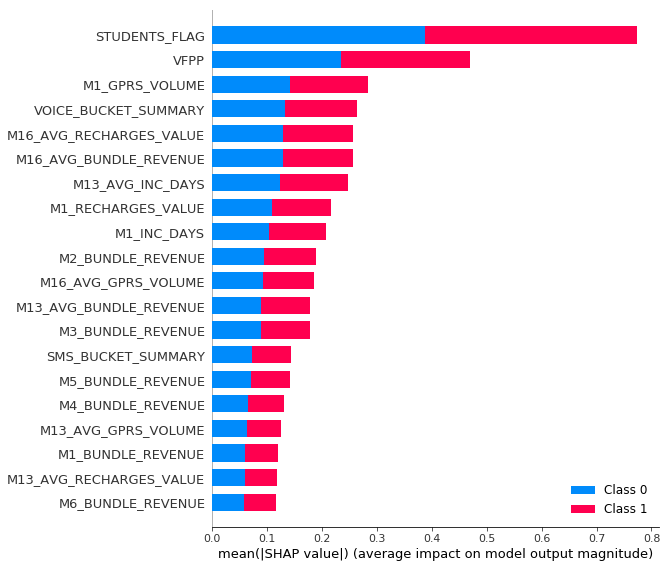

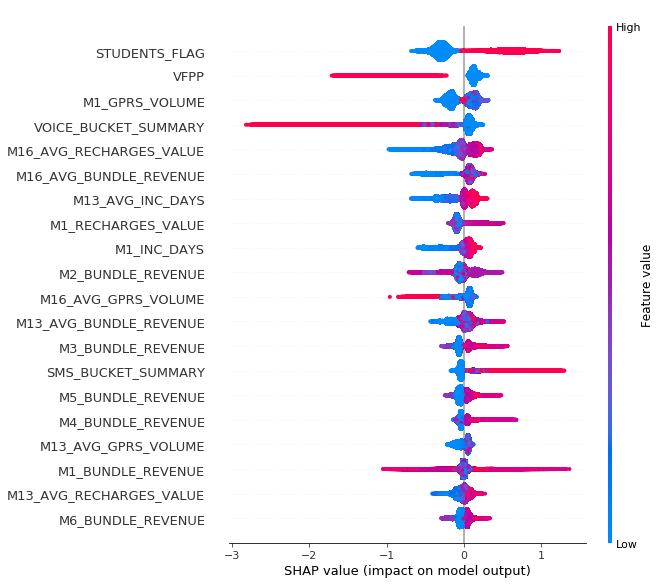

In [ ]:
shap.summary_plot(shap_values, X_previous_test, feature_names, plot_type="bar")
    
shap.summary_plot(shap_values[1], X_previous_test, feature_names, plot_type="dot")

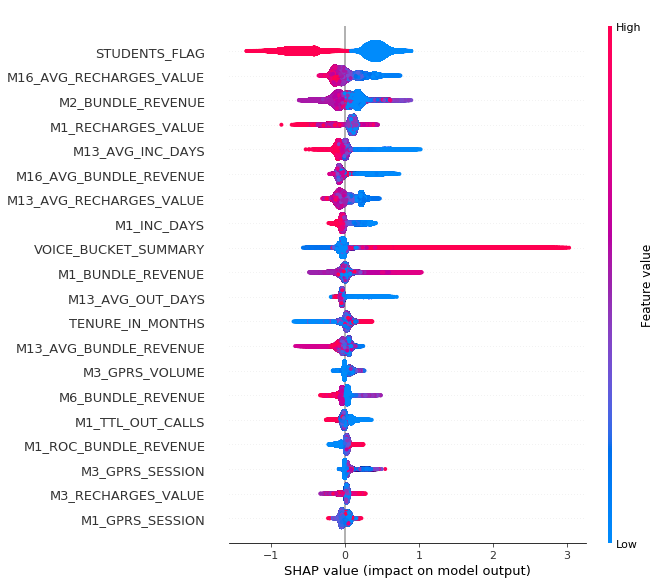

In [38]:
#shap.summary_plot(shap_values[0], X_previous_test, feature_names, plot_type="dot")

# SAVE MODEL

In [38]:
import joblib
from google.cloud import storage

In [35]:
output_bucket_new = "vf-gr-ca-nonlive-devds"

In [33]:
# Save model artifact to local filesystem (doesn't persist)
local_path = 'model.pkl'
joblib.dump(lgbm, local_path)

['model.pkl']

In [36]:
out_dir = 'gs://'+ output_bucket_new +'/modeloutputs/push2higher/tariff_all/'

In [39]:
# Upload model artifact to Cloud Storage
#model_directory = os.environ['AIP_MODEL_DIR']
model_directory = out_dir
storage_path = os.path.join(model_directory, 'model.pkl')
blob = storage.blob.Blob.from_string(storage_path, client=storage.Client())
blob.upload_from_filename(local_path)

### LightGBM Tuning

In [94]:
# BORUTA
for booster in ['gbdt', 'dart', 'goss']:
    for scale in [3]:
    #for scale in [feb_proportion/2, feb_proportion]:
        for est in [100, 500, 1000]:
            for lr in [0.01, 0.1]:
                print (booster, scale, est, lr)
                # ----------------TRAINING-------------------
                lgbm = lgb.LGBMClassifier(boosting_type = booster,
                                    importance_type = 'gain',
                                    scale_pos_weight= scale,
                                    n_estimators = est,
                                    learning_rate=lr, metric='auc', silent=True, n_jobs=-1, random_state=10) 

                lgbm.fit(X_previous_train_new, y_previous_train)                
                # ----------------TESTING-------------------
                cm, acc, class_report = evaluation(X_previous_test, y_previous_test, lgbm)
                print(cm)
                print(acc)
                print(class_report)

                # -----------------EVALUATION-------------------
                pred_y_propab = lgbm.predict_proba(X_previous_test)
                pred_y_propab[:,1]
                condition = pred_y_propab[:,1] >= 0.5
                len(pred_y_propab[:,1][condition])

gbdt 3 100 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[1145343  178142]
 [  19431   17106]]
0.8547280852809734
                  precision    recall  f1-score   support

No higher bundle       0.98      0.87      0.92   1323485
   Higher Bundle       0.09      0.47      0.15     36537

        accuracy                           0.85   1360022
       macro avg       0.54      0.67      0.53   1360022
    weighted avg       0.96      0.85      0.90   1360022



array([0.37214631, 0.57041653, 0.55064378, ..., 0.13923794, 0.35958509,
       0.17976555])

195248

gbdt 3 100 0.1


LGBMClassifier(importance_type='gain', metric='auc', random_state=10,
               scale_pos_weight=3, silent=True)

[[947867 375618]
 [  8259  28278]]
0.7177420659371687
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.77      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.75      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



array([0.41746232, 0.47647258, 0.75883453, ..., 0.05629935, 0.49857355,
       0.07086868])

403896

gbdt 3 500 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[940610 382875]
 [  8188  28349]]
0.7124583278799902
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83   1323485
   Higher Bundle       0.07      0.78      0.13     36537

        accuracy                           0.71   1360022
       macro avg       0.53      0.74      0.48   1360022
    weighted avg       0.97      0.71      0.81   1360022



array([0.42686363, 0.60512347, 0.76451654, ..., 0.07020207, 0.44402616,
       0.12165847])

411224

gbdt 3 500 0.1


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=500,
               random_state=10, scale_pos_weight=3, silent=True)

[[998566 324919]
 [ 10060  26477]]
0.7536958960957985
                  precision    recall  f1-score   support

No higher bundle       0.99      0.75      0.86   1323485
   Higher Bundle       0.08      0.72      0.14     36537

        accuracy                           0.75   1360022
       macro avg       0.53      0.74      0.50   1360022
    weighted avg       0.97      0.75      0.84   1360022



array([0.30488163, 0.35942167, 0.75066363, ..., 0.03704691, 0.47345616,
       0.05798712])

351396

gbdt 3 1000 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[949650 373835]
 [  8153  28384]]
0.7191310140571255
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.78      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.75      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



array([0.41859182, 0.5174942 , 0.77569405, ..., 0.05931196, 0.45696365,
       0.10963786])

402219

gbdt 3 1000 0.1


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=1000,
               random_state=10, scale_pos_weight=3, silent=True)

[[1035919  287566]
 [  11905   24632]]
0.7798042972834263
                  precision    recall  f1-score   support

No higher bundle       0.99      0.78      0.87   1323485
   Higher Bundle       0.08      0.67      0.14     36537

        accuracy                           0.78   1360022
       macro avg       0.53      0.73      0.51   1360022
    weighted avg       0.96      0.78      0.85   1360022



array([0.29746098, 0.2833738 , 0.70914137, ..., 0.03698237, 0.33930251,
       0.05223892])

312198

dart 3 100 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', random_state=10, scale_pos_weight=3, silent=True)

[[1240227   83258]
 [  26919    9618]]
0.9189888104751247
                  precision    recall  f1-score   support

No higher bundle       0.98      0.94      0.96   1323485
   Higher Bundle       0.10      0.26      0.15     36537

        accuracy                           0.92   1360022
       macro avg       0.54      0.60      0.55   1360022
    weighted avg       0.96      0.92      0.94   1360022



array([0.42748943, 0.50949665, 0.50957567, ..., 0.29287845, 0.40570672,
       0.32793455])

92876

dart 3 100 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[945515 377970]
 [  8680  27857]]
0.7157031283317475
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83   1323485
   Higher Bundle       0.07      0.76      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.74      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



array([0.46254964, 0.60607159, 0.71897449, ..., 0.10996159, 0.45337511,
       0.20196491])

405827

dart 3 500 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=500, random_state=10,
               scale_pos_weight=3, silent=True)

[[955608 367877]
 [ 10020  26517]]
0.7221390536329559
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.73      0.12     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.72      0.48   1360022
    weighted avg       0.96      0.72      0.82   1360022



array([0.46988824, 0.66219817, 0.64176846, ..., 0.2058642 , 0.445151  ,
       0.26261826])

394394

dart 3 500 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[952331 371154]
 [  8233  28304]]
0.721043483120126
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.77      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.75      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



array([0.38387006, 0.45720283, 0.74716288, ..., 0.0775751 , 0.46593454,
       0.19834141])

399458

dart 3 1000 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=1000, random_state=10,
               scale_pos_weight=3, silent=True)

[[938298 385187]
 [  8849  27688]]
0.710272333829894
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83   1323485
   Higher Bundle       0.07      0.76      0.12     36537

        accuracy                           0.71   1360022
       macro avg       0.53      0.73      0.47   1360022
    weighted avg       0.97      0.71      0.81   1360022



array([0.43272684, 0.6742161 , 0.69785088, ..., 0.14845756, 0.4604886 ,
       0.18643954])

412875

dart 3 1000 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[964458 359027]
 [  8705  27832]]
0.7296131974335709
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84   1323485
   Higher Bundle       0.07      0.76      0.13     36537

        accuracy                           0.73   1360022
       macro avg       0.53      0.75      0.49   1360022
    weighted avg       0.97      0.73      0.82   1360022



array([0.38494961, 0.48376276, 0.74088509, ..., 0.05858245, 0.48821469,
       0.1941581 ])

386859

goss 3 100 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', random_state=10, scale_pos_weight=3, silent=True)

[[1145343  178142]
 [  19431   17106]]
0.8547280852809734
                  precision    recall  f1-score   support

No higher bundle       0.98      0.87      0.92   1323485
   Higher Bundle       0.09      0.47      0.15     36537

        accuracy                           0.85   1360022
       macro avg       0.54      0.67      0.53   1360022
    weighted avg       0.96      0.85      0.90   1360022



array([0.37214631, 0.57041653, 0.55064378, ..., 0.13923794, 0.35958509,
       0.17976555])

195248

goss 3 100 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[948560 374925]
 [  8621  27916]]
0.7179854443531061
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.76      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.74      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



array([0.32774502, 0.55152028, 0.77298468, ..., 0.06358139, 0.44906269,
       0.08577024])

402841

goss 3 500 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=500, random_state=10,
               scale_pos_weight=3, silent=True)

[[941411 382074]
 [  8286  28251]]
0.7129752312830233
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83   1323485
   Higher Bundle       0.07      0.77      0.13     36537

        accuracy                           0.71   1360022
       macro avg       0.53      0.74      0.48   1360022
    weighted avg       0.97      0.71      0.81   1360022



array([0.43145451, 0.6330583 , 0.74677771, ..., 0.08235124, 0.45154448,
       0.12748108])

410325

goss 3 500 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[998472 325013]
 [ 11104  25433]]
0.7528591449255968
                  precision    recall  f1-score   support

No higher bundle       0.99      0.75      0.86   1323485
   Higher Bundle       0.07      0.70      0.13     36537

        accuracy                           0.75   1360022
       macro avg       0.53      0.73      0.49   1360022
    weighted avg       0.96      0.75      0.84   1360022



array([0.27797821, 0.48778236, 0.78924189, ..., 0.04702989, 0.38528759,
       0.09540504])

350446

goss 3 1000 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=1000, random_state=10,
               scale_pos_weight=3, silent=True)

[[950492 372993]
 [  8318  28219]]
0.719628800122351
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.77      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.75      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



array([0.42388401, 0.59821513, 0.74359426, ..., 0.07569843, 0.45790059,
       0.11370667])

401212

goss 3 1000 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[1038969  284516]
 [  13649   22888]]
0.7807645758671551
                  precision    recall  f1-score   support

No higher bundle       0.99      0.79      0.87   1323485
   Higher Bundle       0.07      0.63      0.13     36537

        accuracy                           0.78   1360022
       macro avg       0.53      0.71      0.50   1360022
    weighted avg       0.96      0.78      0.85   1360022



array([0.27216104, 0.32628845, 0.72076033, ..., 0.05689296, 0.40770401,
       0.12376254])

307404

In [31]:
for booster in ['gbdt', 'dart', 'goss']:
    for scale in [3]:
    #for scale in [feb_proportion/2, feb_proportion]:
        for est in [100, 500, 1000]:
            for lr in [0.01, 0.1]:
                print (booster, scale, est, lr)
                # ----------------TRAINING-------------------
                lgbm = lgb.LGBMClassifier(boosting_type = booster,
                                    importance_type = 'gain',
                                    scale_pos_weight= scale,
                                    n_estimators = est,
                                    learning_rate=lr, metric='auc', silent=True, n_jobs=-1, random_state=10) 

                lgbm.fit(X_previous_train_new, y_previous_train)                
                # ----------------TESTING-------------------
                cm, acc, class_report = evaluation(X_previous_test, y_previous_test, lgbm)
                print(cm)
                print(acc)
                print(class_report)

                # -----------------EVALUATION-------------------
                pred_y_propab = lgbm.predict_proba(X_previous_test)
                pred_y_propab[:,1]
                condition = pred_y_propab[:,1] >= 0.5
                len(pred_y_propab[:,1][condition])

gbdt 3 100 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[1146709  176776]
 [  19485   17052]]
0.8556927755580425
                  precision    recall  f1-score   support

No higher bundle       0.98      0.87      0.92   1323485
   Higher Bundle       0.09      0.47      0.15     36537

        accuracy                           0.86   1360022
       macro avg       0.54      0.67      0.53   1360022
    weighted avg       0.96      0.86      0.90   1360022



array([0.36246486, 0.56769218, 0.55130353, ..., 0.13540426, 0.35682546,
       0.17252178])

193828

gbdt 3 100 0.1


LGBMClassifier(importance_type='gain', metric='auc', random_state=10,
               scale_pos_weight=3, silent=True)

[[969061 354424]
 [  8796  27741]]
0.7329307908254425
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84   1323485
   Higher Bundle       0.07      0.76      0.13     36537

        accuracy                           0.73   1360022
       macro avg       0.53      0.75      0.49   1360022
    weighted avg       0.97      0.73      0.82   1360022



array([0.3986418 , 0.56407814, 0.72574359, ..., 0.04243075, 0.41713781,
       0.0529061 ])

382165

gbdt 3 500 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[944959 378526]
 [  8260  28277]]
0.7156031299493685
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83   1323485
   Higher Bundle       0.07      0.77      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.74      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



array([0.35230023, 0.62412866, 0.69585863, ..., 0.06595153, 0.42683596,
       0.0907121 ])

406803

gbdt 3 500 0.1


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=500,
               random_state=10, scale_pos_weight=3, silent=True)

[[1070154  253331]
 [  13613   22924]]
0.8037208221631709
                  precision    recall  f1-score   support

No higher bundle       0.99      0.81      0.89   1323485
   Higher Bundle       0.08      0.63      0.15     36537

        accuracy                           0.80   1360022
       macro avg       0.54      0.72      0.52   1360022
    weighted avg       0.96      0.80      0.87   1360022



array([0.38643321, 0.55798493, 0.72801993, ..., 0.03091449, 0.48429227,
       0.03074303])

276255

gbdt 3 1000 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[964048 359437]
 [  8543  27994]]
0.7294308474421737
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84   1323485
   Higher Bundle       0.07      0.77      0.13     36537

        accuracy                           0.73   1360022
       macro avg       0.53      0.75      0.49   1360022
    weighted avg       0.97      0.73      0.82   1360022



array([0.32799727, 0.54165601, 0.69166092, ..., 0.05134025, 0.41544679,
       0.07510947])

387431

gbdt 3 1000 0.1


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=1000,
               random_state=10, scale_pos_weight=3, silent=True)

[[1137746  185739]
 [  18271   18266]]
0.8499950736091034
                  precision    recall  f1-score   support

No higher bundle       0.98      0.86      0.92   1323485
   Higher Bundle       0.09      0.50      0.15     36537

        accuracy                           0.85   1360022
       macro avg       0.54      0.68      0.53   1360022
    weighted avg       0.96      0.85      0.90   1360022



array([0.2463126 , 0.47792308, 0.69078931, ..., 0.01279225, 0.4270659 ,
       0.01499908])

204005

dart 3 100 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', random_state=10, scale_pos_weight=3, silent=True)

[[1240338   83147]
 [  26987    9550]]
0.9190204276107298
                  precision    recall  f1-score   support

No higher bundle       0.98      0.94      0.96   1323485
   Higher Bundle       0.10      0.26      0.15     36537

        accuracy                           0.92   1360022
       macro avg       0.54      0.60      0.55   1360022
    weighted avg       0.96      0.92      0.94   1360022



array([0.41533511, 0.50963524, 0.51124572, ..., 0.29293124, 0.40593779,
       0.32942278])

92697

dart 3 100 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[951457 372028]
 [  8688  27849]]
0.7200662930452596
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.76      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.74      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



array([0.40894773, 0.62640388, 0.67284474, ..., 0.10730712, 0.45712572,
       0.12322393])

399877

dart 3 500 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=500, random_state=10,
               scale_pos_weight=3, silent=True)

[[955279 368206]
 [  9988  26549]]
0.7219206748126133
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.73      0.12     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.72      0.48   1360022
    weighted avg       0.96      0.72      0.82   1360022



array([0.47168966, 0.66354135, 0.64541444, ..., 0.20177824, 0.44121484,
       0.25805666])

394755

dart 3 500 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[964052 359433]
 [  8448  28089]]
0.729503640382288
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84   1323485
   Higher Bundle       0.07      0.77      0.13     36537

        accuracy                           0.73   1360022
       macro avg       0.53      0.75      0.49   1360022
    weighted avg       0.97      0.73      0.82   1360022



array([0.28903401, 0.52788853, 0.71026817, ..., 0.06308144, 0.46015709,
       0.11869599])

387522

dart 3 1000 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=1000, random_state=10,
               scale_pos_weight=3, silent=True)

[[941965 381520]
 [  8873  27664]]
0.712950966969652
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83   1323485
   Higher Bundle       0.07      0.76      0.12     36537

        accuracy                           0.71   1360022
       macro avg       0.53      0.73      0.48   1360022
    weighted avg       0.97      0.71      0.81   1360022



array([0.45167194, 0.6953421 , 0.67504123, ..., 0.13451127, 0.4666913 ,
       0.17518758])

409184

dart 3 1000 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[985688 337797]
 [  9274  27263]]
0.7448048634507383
                  precision    recall  f1-score   support

No higher bundle       0.99      0.74      0.85   1323485
   Higher Bundle       0.07      0.75      0.14     36537

        accuracy                           0.74   1360022
       macro avg       0.53      0.75      0.49   1360022
    weighted avg       0.97      0.74      0.83   1360022



array([0.37204287, 0.35845782, 0.75092305, ..., 0.05497102, 0.40524389,
       0.09604053])

365060

goss 3 100 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', random_state=10, scale_pos_weight=3, silent=True)

[[1146709  176776]
 [  19485   17052]]
0.8556927755580425
                  precision    recall  f1-score   support

No higher bundle       0.98      0.87      0.92   1323485
   Higher Bundle       0.09      0.47      0.15     36537

        accuracy                           0.86   1360022
       macro avg       0.54      0.67      0.53   1360022
    weighted avg       0.96      0.86      0.90   1360022



array([0.36246486, 0.56769218, 0.55130353, ..., 0.13540426, 0.35682546,
       0.17252178])

193828

goss 3 100 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[1001742  321743]
 [  10698   25839]]
0.7555620423787263
                  precision    recall  f1-score   support

No higher bundle       0.99      0.76      0.86   1323485
   Higher Bundle       0.07      0.71      0.13     36537

        accuracy                           0.76   1360022
       macro avg       0.53      0.73      0.50   1360022
    weighted avg       0.96      0.76      0.84   1360022



array([0.23291458, 0.48205097, 0.7607543 , ..., 0.06116122, 0.46634325,
       0.09880388])

347582

goss 3 500 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=500, random_state=10,
               scale_pos_weight=3, silent=True)

[[951503 371982]
 [  8596  27941]]
0.7201677619920854
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83   1323485
   Higher Bundle       0.07      0.76      0.13     36537

        accuracy                           0.72   1360022
       macro avg       0.53      0.74      0.48   1360022
    weighted avg       0.97      0.72      0.81   1360022



array([0.3555324 , 0.61293561, 0.70559966, ..., 0.07129077, 0.43446389,
       0.12145604])

399923

goss 3 500 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[1083522  239963]
 [  16090   20447]]
0.8117287808579567
                  precision    recall  f1-score   support

No higher bundle       0.99      0.82      0.89   1323485
   Higher Bundle       0.08      0.56      0.14     36537

        accuracy                           0.81   1360022
       macro avg       0.53      0.69      0.52   1360022
    weighted avg       0.96      0.81      0.87   1360022



array([0.20002516, 0.52142566, 0.82526787, ..., 0.03444296, 0.43867323,
       0.08823391])

260410

goss 3 1000 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=1000, random_state=10,
               scale_pos_weight=3, silent=True)

[[972407 351078]
 [  8884  27653]]
0.7353263403092009
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84   1323485
   Higher Bundle       0.07      0.76      0.13     36537

        accuracy                           0.74   1360022
       macro avg       0.53      0.75      0.49   1360022
    weighted avg       0.97      0.74      0.82   1360022



array([0.31079238, 0.57230321, 0.70987903, ..., 0.05914276, 0.42350752,
       0.10924113])

378731

goss 3 1000 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[1120933  202552]
 [  19264   17273]]
0.8369026383396739
                  precision    recall  f1-score   support

No higher bundle       0.98      0.85      0.91   1323485
   Higher Bundle       0.08      0.47      0.13     36537

        accuracy                           0.84   1360022
       macro avg       0.53      0.66      0.52   1360022
    weighted avg       0.96      0.84      0.89   1360022



array([0.10770429, 0.44624086, 0.84457569, ..., 0.0142716 , 0.35419117,
       0.06928529])

219825

In [ ]:
# smote

In [56]:
for booster in ['gbdt', 'dart', 'goss']:
    for scale in [3]:
    #for scale in [feb_proportion/2, feb_proportion]:
        for est in [100, 500, 1000]:
            for lr in [0.01, 0.1]:
                print (booster, scale, est, lr)
                # ----------------TRAINING-------------------
                lgbm = lgb.LGBMClassifier(boosting_type = booster,
                                    importance_type = 'gain',
                                    scale_pos_weight= scale,
                                    n_estimators = est,
                                    learning_rate=lr, metric='auc', silent=True, n_jobs=-1, random_state=10) 

                lgbm.fit(X_previous_train_resampled, y_previous_train_resampled)                
                # ----------------TESTING-------------------
                cm, acc, class_report = evaluation(X_previous_test, y_previous_test, lgbm)
                print(cm)
                print(acc)
                print(class_report)

                # -----------------EVALUATION-------------------
                pred_y_propab = lgbm.predict_proba(X_previous_test)
                pred_y_propab[:,1]
                condition = pred_y_propab[:,1] >= 0.5
                len(pred_y_propab[:,1][condition])

gbdt 3 100 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[484809 487953]
 [  4295  24128]]
0.5083346234711866
                  precision    recall  f1-score   support

No higher bundle       0.99      0.50      0.66    972762
   Higher Bundle       0.05      0.85      0.09     28423

        accuracy                           0.51   1001185
       macro avg       0.52      0.67      0.38   1001185
    weighted avg       0.96      0.51      0.65   1001185



array([0.31146048, 0.60787566, 0.19168723, ..., 0.38594116, 0.67310322,
       0.45199035])

512081

gbdt 3 100 0.1


LGBMClassifier(importance_type='gain', metric='auc', random_state=10,
               scale_pos_weight=3, silent=True)

[[624325 348437]
 [  5705  22718]]
0.6462771615635472
                  precision    recall  f1-score   support

No higher bundle       0.99      0.64      0.78    972762
   Higher Bundle       0.06      0.80      0.11     28423

        accuracy                           0.65   1001185
       macro avg       0.53      0.72      0.45   1001185
    weighted avg       0.96      0.65      0.76   1001185



array([0.13359827, 0.7493834 , 0.02511589, ..., 0.3834741 , 0.69001858,
       0.34548139])

371155

gbdt 3 500 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[569942 402820]
 [  4799  23624]]
0.5928634568036877
                  precision    recall  f1-score   support

No higher bundle       0.99      0.59      0.74    972762
   Higher Bundle       0.06      0.83      0.10     28423

        accuracy                           0.59   1001185
       macro avg       0.52      0.71      0.42   1001185
    weighted avg       0.97      0.59      0.72   1001185



array([0.17181294, 0.73411212, 0.04172448, ..., 0.38579904, 0.71746238,
       0.44024542])

426444

gbdt 3 500 0.1


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=500,
               random_state=10, scale_pos_weight=3, silent=True)

[[706611 266151]
 [  9033  19390]]
0.7251417070771137
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    972762
   Higher Bundle       0.07      0.68      0.12     28423

        accuracy                           0.73   1001185
       macro avg       0.53      0.70      0.48   1001185
    weighted avg       0.96      0.73      0.82   1001185



array([0.09531732, 0.83202759, 0.01263406, ..., 0.3914393 , 0.48361874,
       0.13384066])

285541

gbdt 3 1000 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[622716 350046]
 [  5648  22775]]
0.6447269985067695
                  precision    recall  f1-score   support

No higher bundle       0.99      0.64      0.78    972762
   Higher Bundle       0.06      0.80      0.11     28423

        accuracy                           0.64   1001185
       macro avg       0.53      0.72      0.45   1001185
    weighted avg       0.96      0.64      0.76   1001185



array([0.13378391, 0.7229676 , 0.02455319, ..., 0.39825331, 0.70594463,
       0.37463939])

372821

gbdt 3 1000 0.1


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=1000,
               random_state=10, scale_pos_weight=3, silent=True)

[[784322 188440]
 [ 13281  15142]]
0.7985177564585966
                  precision    recall  f1-score   support

No higher bundle       0.98      0.81      0.89    972762
   Higher Bundle       0.07      0.53      0.13     28423

        accuracy                           0.80   1001185
       macro avg       0.53      0.67      0.51   1001185
    weighted avg       0.96      0.80      0.86   1001185



array([0.05347674, 0.80702418, 0.01019539, ..., 0.28361803, 0.31084742,
       0.11264981])

203582

dart 3 100 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', random_state=10, scale_pos_weight=3, silent=True)

[[457455 515307]
 [  4454  23969]]
0.48085418778747185
                  precision    recall  f1-score   support

No higher bundle       0.99      0.47      0.64    972762
   Higher Bundle       0.04      0.84      0.08     28423

        accuracy                           0.48   1001185
       macro avg       0.52      0.66      0.36   1001185
    weighted avg       0.96      0.48      0.62   1001185



array([0.41273616, 0.56136064, 0.35135094, ..., 0.4476211 , 0.59016593,
       0.50744049])

539276

dart 3 100 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[558003 414759]
 [  4712  23711]]
0.5810254848005114
                  precision    recall  f1-score   support

No higher bundle       0.99      0.57      0.73    972762
   Higher Bundle       0.05      0.83      0.10     28423

        accuracy                           0.58   1001185
       macro avg       0.52      0.70      0.41   1001185
    weighted avg       0.97      0.58      0.71   1001185



array([0.23135658, 0.69464799, 0.0764616 , ..., 0.36537821, 0.6738689 ,
       0.42298628])

438470

dart 3 500 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=500, random_state=10,
               scale_pos_weight=3, silent=True)

[[444988 527774]
 [  3333  25090]]
0.46952161688399247
                  precision    recall  f1-score   support

No higher bundle       0.99      0.46      0.63    972762
   Higher Bundle       0.05      0.88      0.09     28423

        accuracy                           0.47   1001185
       macro avg       0.52      0.67      0.36   1001185
    weighted avg       0.97      0.47      0.61   1001185



array([0.32927649, 0.62507811, 0.202709  , ..., 0.42634204, 0.71155355,
       0.48645637])

552864

dart 3 500 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[637189 335573]
 [  5840  22583]]
0.6589910955517712
                  precision    recall  f1-score   support

No higher bundle       0.99      0.66      0.79    972762
   Higher Bundle       0.06      0.79      0.12     28423

        accuracy                           0.66   1001185
       macro avg       0.53      0.72      0.45   1001185
    weighted avg       0.96      0.66      0.77   1001185



array([0.13649876, 0.70151493, 0.02383874, ..., 0.39947167, 0.57961776,
       0.37549675])

358156

dart 3 1000 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=1000, random_state=10,
               scale_pos_weight=3, silent=True)

[[519090 453672]
 [  4202  24221]]
0.542667938492886
                  precision    recall  f1-score   support

No higher bundle       0.99      0.53      0.69    972762
   Higher Bundle       0.05      0.85      0.10     28423

        accuracy                           0.54   1001185
       macro avg       0.52      0.69      0.39   1001185
    weighted avg       0.97      0.54      0.68   1001185



array([0.27394276, 0.66791328, 0.120559  , ..., 0.37451598, 0.72074723,
       0.45368909])

477893

dart 3 1000 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[676322 296440]
 [  6890  21533]]
0.6970290206105765
                  precision    recall  f1-score   support

No higher bundle       0.99      0.70      0.82    972762
   Higher Bundle       0.07      0.76      0.12     28423

        accuracy                           0.70   1001185
       macro avg       0.53      0.73      0.47   1001185
    weighted avg       0.96      0.70      0.80   1001185



array([0.12035696, 0.57977176, 0.01552706, ..., 0.34963554, 0.43021747,
       0.36801228])

317973

goss 3 100 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', random_state=10, scale_pos_weight=3, silent=True)

[[484809 487953]
 [  4295  24128]]
0.5083346234711866
                  precision    recall  f1-score   support

No higher bundle       0.99      0.50      0.66    972762
   Higher Bundle       0.05      0.85      0.09     28423

        accuracy                           0.51   1001185
       macro avg       0.52      0.67      0.38   1001185
    weighted avg       0.96      0.51      0.65   1001185



array([0.31146048, 0.60787566, 0.19168723, ..., 0.38594116, 0.67310322,
       0.45199035])

512081

goss 3 100 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[639375 333387]
 [  6746  21677]]
0.6602695805470518
                  precision    recall  f1-score   support

No higher bundle       0.99      0.66      0.79    972762
   Higher Bundle       0.06      0.76      0.11     28423

        accuracy                           0.66   1001185
       macro avg       0.53      0.71      0.45   1001185
    weighted avg       0.96      0.66      0.77   1001185



array([0.18664748, 0.68652453, 0.01763144, ..., 0.27816471, 0.76690175,
       0.4137752 ])

355064

goss 3 500 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=500, random_state=10,
               scale_pos_weight=3, silent=True)

[[579707 393055]
 [  5121  23302]]
0.6022952800930896
                  precision    recall  f1-score   support

No higher bundle       0.99      0.60      0.74    972762
   Higher Bundle       0.06      0.82      0.10     28423

        accuracy                           0.60   1001185
       macro avg       0.52      0.71      0.42   1001185
    weighted avg       0.96      0.60      0.73   1001185



array([0.17257671, 0.67725997, 0.04367482, ..., 0.35488433, 0.73034736,
       0.43058143])

416357

goss 3 500 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[760333 212429]
 [ 12900  15523]]
0.7749376988268901
                  precision    recall  f1-score   support

No higher bundle       0.98      0.78      0.87    972762
   Higher Bundle       0.07      0.55      0.12     28423

        accuracy                           0.77   1001185
       macro avg       0.53      0.66      0.50   1001185
    weighted avg       0.96      0.77      0.85   1001185



array([0.11040487, 0.27370846, 0.02615312, ..., 0.20356723, 0.38628746,
       0.33654866])

227952

goss 3 1000 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=1000, random_state=10,
               scale_pos_weight=3, silent=True)

[[649609 323153]
 [  6602  21821]]
0.6706352971728502
                  precision    recall  f1-score   support

No higher bundle       0.99      0.67      0.80    972762
   Higher Bundle       0.06      0.77      0.12     28423

        accuracy                           0.67   1001185
       macro avg       0.53      0.72      0.46   1001185
    weighted avg       0.96      0.67      0.78   1001185



array([0.16107001, 0.66743521, 0.0274841 , ..., 0.38248135, 0.66410989,
       0.38628882])

344974

goss 3 1000 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[813821 158941]
 [ 16134  12289]]
0.8251322183212892
                  precision    recall  f1-score   support

No higher bundle       0.98      0.84      0.90    972762
   Higher Bundle       0.07      0.43      0.12     28423

        accuracy                           0.83   1001185
       macro avg       0.53      0.63      0.51   1001185
    weighted avg       0.95      0.83      0.88   1001185



array([0.07563709, 0.12987196, 0.01866295, ..., 0.27263045, 0.16450652,
       0.30755513])

171230

In [ ]:
# new dataset (me diorthwseis)

In [30]:
for booster in ['gbdt', 'dart', 'goss']:
    for scale in [3]:
    #for scale in [feb_proportion/2, feb_proportion]:
        for est in [100, 500, 1000]:
            for lr in [0.01, 0.1]:
                print (booster, scale, est, lr)
                # ----------------TRAINING-------------------
                lgbm = lgb.LGBMClassifier(boosting_type = booster,
                                    importance_type = 'gain',
                                    scale_pos_weight= scale,
                                    n_estimators = est,
                                    learning_rate=lr, metric='auc', silent=True, n_jobs=-1, random_state=10) 

                lgbm.fit(X_previous_train_new, y_previous_train)                
                # ----------------TESTING-------------------
                cm, acc, class_report = evaluation(X_previous_test, y_previous_test, lgbm)
                print(cm)
                print(acc)
                print(class_report)

                # -----------------EVALUATION-------------------
                pred_y_propab = lgbm.predict_proba(X_previous_test)
                pred_y_propab[:,1]
                condition = pred_y_propab[:,1] >= 0.5
                len(pred_y_propab[:,1][condition])

gbdt 3 100 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[794254 178508]
 [ 14174  14249]]
0.8075460579213631
                  precision    recall  f1-score   support

No higher bundle       0.98      0.82      0.89    972762
   Higher Bundle       0.07      0.50      0.13     28423

        accuracy                           0.81   1001185
       macro avg       0.53      0.66      0.51   1001185
    weighted avg       0.96      0.81      0.87   1001185



array([0.16125697, 0.52445287, 0.12750899, ..., 0.38978146, 0.53887521,
       0.31162045])

192757

gbdt 3 100 0.1


LGBMClassifier(importance_type='gain', metric='auc', random_state=10,
               scale_pos_weight=3, silent=True)

[[648392 324370]
 [  6168  22255]]
0.6698532239296434
                  precision    recall  f1-score   support

No higher bundle       0.99      0.67      0.80    972762
   Higher Bundle       0.06      0.78      0.12     28423

        accuracy                           0.67   1001185
       macro avg       0.53      0.72      0.46   1001185
    weighted avg       0.96      0.67      0.78   1001185



array([0.09524343, 0.74553862, 0.02809416, ..., 0.4102117 , 0.63285708,
       0.39340104])

346625

gbdt 3 500 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[631291 341471]
 [  6004  22419]]
0.6529362705194345
                  precision    recall  f1-score   support

No higher bundle       0.99      0.65      0.78    972762
   Higher Bundle       0.06      0.79      0.11     28423

        accuracy                           0.65   1001185
       macro avg       0.53      0.72      0.45   1001185
    weighted avg       0.96      0.65      0.77   1001185



array([0.10265149, 0.72112668, 0.03636216, ..., 0.45891637, 0.65655258,
       0.36543579])

363890

gbdt 3 500 0.1


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=500,
               random_state=10, scale_pos_weight=3, silent=True)

[[749197 223565]
 [ 10529  17894]]
0.7661830730584258
                  precision    recall  f1-score   support

No higher bundle       0.99      0.77      0.86    972762
   Higher Bundle       0.07      0.63      0.13     28423

        accuracy                           0.77   1001185
       macro avg       0.53      0.70      0.50   1001185
    weighted avg       0.96      0.77      0.84   1001185



array([0.06891283, 0.75548294, 0.01855461, ..., 0.35230539, 0.39672502,
       0.32071116])

241459

gbdt 3 1000 0.01


KeyboardInterrupt: 

In [ ]:
# new dataset (me new usage)

In [ ]:
for booster in ['gbdt', 'dart', 'goss']:
    for scale in [3]:
    #for scale in [feb_proportion/2, feb_proportion]:
        for est in [100, 500, 1000]:
            for lr in [0.01, 0.1]:
                print (booster, scale, est, lr)
                # ----------------TRAINING-------------------
                lgbm = lgb.LGBMClassifier(boosting_type = booster,
                                    importance_type = 'gain',
                                    scale_pos_weight= scale,
                                    n_estimators = est,
                                    learning_rate=lr, metric='auc', silent=True, n_jobs=-1, random_state=10) 

                lgbm.fit(X_previous_train_new, y_previous_train)                
                # ----------------TESTING-------------------
                cm, acc, class_report = evaluation(X_previous_test, y_previous_test, lgbm)
                print(cm)
                print(acc)
                print(class_report)

                # -----------------EVALUATION-------------------
                pred_y_propab = lgbm.predict_proba(X_previous_test)
                pred_y_propab[:,1]
                condition = pred_y_propab[:,1] >= 0.5
                len(pred_y_propab[:,1][condition])

gbdt 3 100 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[897901  69904]
 [ 24948   9145]]
0.9053276880480847
                  precision    recall  f1-score   support

No higher bundle       0.97      0.93      0.95    967805
   Higher Bundle       0.12      0.27      0.16     34093

        accuracy                           0.91   1001898
       macro avg       0.54      0.60      0.56   1001898
    weighted avg       0.94      0.91      0.92   1001898



array([0.30941694, 0.50560081, 0.51252791, ..., 0.27570286, 0.40418088,
       0.36339989])

79049

gbdt 3 100 0.1


LGBMClassifier(importance_type='gain', metric='auc', random_state=10,
               scale_pos_weight=3, silent=True)

[[677118 290687]
 [  8889  25204]]
0.7009915180986488
                  precision    recall  f1-score   support

No higher bundle       0.99      0.70      0.82    967805
   Higher Bundle       0.08      0.74      0.14     34093

        accuracy                           0.70   1001898
       macro avg       0.53      0.72      0.48   1001898
    weighted avg       0.96      0.70      0.80   1001898



array([0.2737548 , 0.37838769, 0.67929221, ..., 0.22552577, 0.637758  ,
       0.48330754])

315891

gbdt 3 500 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[686040 281765]
 [  9234  24859]]
0.7095522697919349
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83    967805
   Higher Bundle       0.08      0.73      0.15     34093

        accuracy                           0.71   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.71      0.80   1001898



array([0.29102492, 0.5177632 , 0.63985451, ..., 0.24710629, 0.5561025 ,
       0.47868311])

306624

gbdt 3 500 0.1


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=500,
               random_state=10, scale_pos_weight=3, silent=True)

[[742921 224884]
 [ 12557  21536]]
0.7630088092799866
                  precision    recall  f1-score   support

No higher bundle       0.98      0.77      0.86    967805
   Higher Bundle       0.09      0.63      0.15     34093

        accuracy                           0.76   1001898
       macro avg       0.54      0.70      0.51   1001898
    weighted avg       0.95      0.76      0.84   1001898



array([0.16364649, 0.3917699 , 0.62412522, ..., 0.25560126, 0.58790561,
       0.49596753])

246420

gbdt 3 1000 0.01


LGBMClassifier(importance_type='gain', learning_rate=0.01, metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[679291 288514]
 [  8799  25294]]
0.7032502310614454
                  precision    recall  f1-score   support

No higher bundle       0.99      0.70      0.82    967805
   Higher Bundle       0.08      0.74      0.15     34093

        accuracy                           0.70   1001898
       macro avg       0.53      0.72      0.48   1001898
    weighted avg       0.96      0.70      0.80   1001898



array([0.30570014, 0.4291827 , 0.74465284, ..., 0.24667068, 0.65843134,
       0.50401657])

313808

gbdt 3 1000 0.1


LGBMClassifier(importance_type='gain', metric='auc', n_estimators=1000,
               random_state=10, scale_pos_weight=3, silent=True)

[[799418 168387]
 [ 16430  17663]]
0.8155331181417669
                  precision    recall  f1-score   support

No higher bundle       0.98      0.83      0.90    967805
   Higher Bundle       0.09      0.52      0.16     34093

        accuracy                           0.82   1001898
       macro avg       0.54      0.67      0.53   1001898
    weighted avg       0.95      0.82      0.87   1001898



array([0.09475577, 0.28797919, 0.59316714, ..., 0.26139247, 0.30730288,
       0.5323992 ])

186050

dart 3 100 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', random_state=10, scale_pos_weight=3, silent=True)

[[948461  19344]
 [ 30924   3169]]
0.9498272279214052
                  precision    recall  f1-score   support

No higher bundle       0.97      0.98      0.97    967805
   Higher Bundle       0.14      0.09      0.11     34093

        accuracy                           0.95   1001898
       macro avg       0.55      0.54      0.54   1001898
    weighted avg       0.94      0.95      0.94   1001898



array([0.38994634, 0.4833447 , 0.48715892, ..., 0.36935504, 0.43716955,
       0.40663235])

22513

dart 3 100 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[694196 273609]
 [  9843  24250]]
0.7170849727217741
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.71      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.71      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.32176562, 0.53267207, 0.61116058, ..., 0.26590986, 0.56106085,
       0.46224797])

297859

dart 3 500 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=500, random_state=10,
               scale_pos_weight=3, silent=True)

[[684130 283675]
 [ 10719  23374]]
0.7061637012949422
                  precision    recall  f1-score   support

No higher bundle       0.98      0.71      0.82    967805
   Higher Bundle       0.08      0.69      0.14     34093

        accuracy                           0.71   1001898
       macro avg       0.53      0.70      0.48   1001898
    weighted avg       0.95      0.71      0.80   1001898



array([0.39282287, 0.59344156, 0.61432266, ..., 0.35308962, 0.4966965 ,
       0.46636056])

307049

dart 3 500 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               n_estimators=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[689183 278622]
 [  9058  25035]]
0.7128649822636636
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83    967805
   Higher Bundle       0.08      0.73      0.15     34093

        accuracy                           0.71   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.71      0.80   1001898



array([0.28209968, 0.47878344, 0.66916312, ..., 0.24333536, 0.63896136,
       0.54899212])

303657

dart 3 1000 0.01


LGBMClassifier(boosting_type='dart', importance_type='gain', learning_rate=0.01,
               metric='auc', n_estimators=1000, random_state=10,
               scale_pos_weight=3, silent=True)

[[678790 289015]
 [  9684  24409]]
0.701866856705972
                  precision    recall  f1-score   support

No higher bundle       0.99      0.70      0.82    967805
   Higher Bundle       0.08      0.72      0.14     34093

        accuracy                           0.70   1001898
       macro avg       0.53      0.71      0.48   1001898
    weighted avg       0.96      0.70      0.80   1001898



array([0.33943819, 0.56710749, 0.63639636, ..., 0.31039925, 0.52581143,
       0.48315587])

313424

dart 3 1000 0.1


LGBMClassifier(boosting_type='dart', importance_type='gain', metric='auc',
               n_estimators=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[705034 262771]
 [  9848  24245]]
0.7278974506386877
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    967805
   Higher Bundle       0.08      0.71      0.15     34093

        accuracy                           0.73   1001898
       macro avg       0.54      0.72      0.49   1001898
    weighted avg       0.96      0.73      0.81   1001898



array([0.27807634, 0.36208956, 0.72240946, ..., 0.22672901, 0.65513406,
       0.63410832])

287016

goss 3 100 0.01


LGBMClassifier(boosting_type='goss', importance_type='gain', learning_rate=0.01,
               metric='auc', random_state=10, scale_pos_weight=3, silent=True)

[[897901  69904]
 [ 24948   9145]]
0.9053276880480847
                  precision    recall  f1-score   support

No higher bundle       0.97      0.93      0.95    967805
   Higher Bundle       0.12      0.27      0.16     34093

        accuracy                           0.91   1001898
       macro avg       0.54      0.60      0.56   1001898
    weighted avg       0.94      0.91      0.92   1001898



array([0.30941694, 0.50560081, 0.51252791, ..., 0.27570286, 0.40418088,
       0.36339989])

79049

goss 3 100 0.1


LGBMClassifier(boosting_type='goss', importance_type='gain', metric='auc',
               random_state=10, scale_pos_weight=3, silent=True)

[[685344 282461]
 [  9451  24642]]
0.7086409993831707
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.82    967805
   Higher Bundle       0.08      0.72      0.14     34093

        accuracy                           0.71   1001898
       macro avg       0.53      0.72      0.48   1001898
    weighted avg       0.96      0.71      0.80   1001898



KeyboardInterrupt: 

In [28]:
for depth in [-1,7,8]:
#for scale in [feb_proportion/2, feb_proportion]:
    for leaves in [31, 70, 127]:
        for min_data in [20, 100, 500, 1000]:
            print (depth, leaves, min_data)
            # ----------------TRAINING-------------------
            lgbm = lgb.LGBMClassifier(boosting_type = "gbdt",
                                importance_type = 'gain',
                                scale_pos_weight= 3,
                                n_estimators = 100,
                                learning_rate=0.1, metric='auc', silent=True, n_jobs=-1, random_state=10,
                                max_depth= depth, num_leaves=leaves, min_data_in_leaf = min_data) 

            lgbm.fit(X_previous_train_new, y_previous_train)                
            # ----------------TESTING-------------------
            cm, acc, class_report = evaluation(X_previous_test, y_previous_test, lgbm)
            print(cm)
            print(acc)
            print(class_report)

            # -----------------EVALUATION-------------------
            pred_y_propab = lgbm.predict_proba(X_previous_test)
            pred_y_propab[:,1]
            condition = pred_y_propab[:,1] >= 0.5
            len(pred_y_propab[:,1][condition])

-1 31 20


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=20,
               random_state=10, scale_pos_weight=3, silent=True)

[[677118 290687]
 [  8889  25204]]
0.7009915180986488
                  precision    recall  f1-score   support

No higher bundle       0.99      0.70      0.82    967805
   Higher Bundle       0.08      0.74      0.14     34093

        accuracy                           0.70   1001898
       macro avg       0.53      0.72      0.48   1001898
    weighted avg       0.96      0.70      0.80   1001898



array([0.2737548 , 0.37838769, 0.67929221, ..., 0.22552577, 0.637758  ,
       0.48330754])

315891

-1 31 100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=100,
               random_state=10, scale_pos_weight=3, silent=True)

[[679140 288665]
 [  8844  25249]]
0.7030546023647117
                  precision    recall  f1-score   support

No higher bundle       0.99      0.70      0.82    967805
   Higher Bundle       0.08      0.74      0.15     34093

        accuracy                           0.70   1001898
       macro avg       0.53      0.72      0.48   1001898
    weighted avg       0.96      0.70      0.80   1001898



array([0.29113728, 0.46910662, 0.71436909, ..., 0.2366945 , 0.54400142,
       0.5045757 ])

313914

-1 31 500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=500,
               random_state=10, scale_pos_weight=3, silent=True)

[[687945 279860]
 [  9007  25086]]
0.7116802309217106
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83    967805
   Higher Bundle       0.08      0.74      0.15     34093

        accuracy                           0.71   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.71      0.80   1001898



array([0.26649275, 0.44686081, 0.64266945, ..., 0.23937766, 0.58321388,
       0.51420185])

304946

-1 31 1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=1000,
               random_state=10, scale_pos_weight=3, silent=True)

[[704845 262960]
 [  9828  24265]]
0.7277287707930348
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    967805
   Higher Bundle       0.08      0.71      0.15     34093

        accuracy                           0.73   1001898
       macro avg       0.54      0.72      0.49   1001898
    weighted avg       0.96      0.73      0.81   1001898



array([0.26926896, 0.42186137, 0.66078445, ..., 0.27199793, 0.57924138,
       0.53612103])

287225

-1 70 20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=20,
               num_leaves=70, random_state=10, scale_pos_weight=3, silent=True)

[[694067 273738]
 [  9626  24467]]
0.7171728060141851
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.19214954, 0.55097643, 0.78881134, ..., 0.32462787, 0.61615352,
       0.52659706])

298205

-1 70 100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=100,
               num_leaves=70, random_state=10, scale_pos_weight=3, silent=True)

[[688651 279154]
 [  9204  24889]]
0.7121882666698606
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83    967805
   Higher Bundle       0.08      0.73      0.15     34093

        accuracy                           0.71   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.71      0.80   1001898



array([0.25638058, 0.42645614, 0.65582664, ..., 0.28894535, 0.72123452,
       0.46992411])

304043

-1 70 500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=500,
               num_leaves=70, random_state=10, scale_pos_weight=3, silent=True)

[[716896 250909]
 [ 10236  23857]]
0.739349714242368
                  precision    recall  f1-score   support

No higher bundle       0.99      0.74      0.85    967805
   Higher Bundle       0.09      0.70      0.15     34093

        accuracy                           0.74   1001898
       macro avg       0.54      0.72      0.50   1001898
    weighted avg       0.96      0.74      0.82   1001898



array([0.1742979 , 0.30724962, 0.58810769, ..., 0.27930311, 0.67031054,
       0.60484501])

274766

-1 70 1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=1000,
               num_leaves=70, random_state=10, scale_pos_weight=3, silent=True)

[[709621 258184]
 [ 10072  24021]]
0.7322521853522015
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    967805
   Higher Bundle       0.09      0.70      0.15     34093

        accuracy                           0.73   1001898
       macro avg       0.54      0.72      0.50   1001898
    weighted avg       0.96      0.73      0.82   1001898



array([0.21518571, 0.33554286, 0.63588319, ..., 0.24219729, 0.58609293,
       0.61851977])

282205

-1 127 20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=20,
               num_leaves=127, random_state=10, scale_pos_weight=3,
               silent=True)

[[723738 244067]
 [ 11238  22855]]
0.7451786509205528
                  precision    recall  f1-score   support

No higher bundle       0.98      0.75      0.85    967805
   Higher Bundle       0.09      0.67      0.15     34093

        accuracy                           0.75   1001898
       macro avg       0.54      0.71      0.50   1001898
    weighted avg       0.95      0.75      0.83   1001898



array([0.30812873, 0.25343195, 0.86681852, ..., 0.23813444, 0.6678687 ,
       0.48155223])

266922

-1 127 100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=100,
               num_leaves=127, random_state=10, scale_pos_weight=3,
               silent=True)

[[718668 249137]
 [ 10560  23533]]
0.7407949711447672
                  precision    recall  f1-score   support

No higher bundle       0.99      0.74      0.85    967805
   Higher Bundle       0.09      0.69      0.15     34093

        accuracy                           0.74   1001898
       macro avg       0.54      0.72      0.50   1001898
    weighted avg       0.95      0.74      0.82   1001898



array([0.20293138, 0.33172937, 0.63728381, ..., 0.23472779, 0.72435532,
       0.54384823])

272670

-1 127 500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=500,
               num_leaves=127, random_state=10, scale_pos_weight=3,
               silent=True)

[[733616 234189]
 [ 11231  22862]]
0.755044924732857
                  precision    recall  f1-score   support

No higher bundle       0.98      0.76      0.86    967805
   Higher Bundle       0.09      0.67      0.16     34093

        accuracy                           0.76   1001898
       macro avg       0.54      0.71      0.51   1001898
    weighted avg       0.95      0.76      0.83   1001898



array([0.21653284, 0.48920359, 0.57348658, ..., 0.22882573, 0.72001319,
       0.61021367])

257051

-1 127 1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


LGBMClassifier(importance_type='gain', metric='auc', min_data_in_leaf=1000,
               num_leaves=127, random_state=10, scale_pos_weight=3,
               silent=True)

[[714333 253472]
 [ 10265  23828]]
0.7367626245386257
                  precision    recall  f1-score   support

No higher bundle       0.99      0.74      0.84    967805
   Higher Bundle       0.09      0.70      0.15     34093

        accuracy                           0.74   1001898
       macro avg       0.54      0.72      0.50   1001898
    weighted avg       0.96      0.74      0.82   1001898



array([0.20138633, 0.44240526, 0.56500573, ..., 0.35910938, 0.48747436,
       0.61890663])

277300

7 31 20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=20, random_state=10, scale_pos_weight=3,
               silent=True)

[[663349 304456]
 [  8482  25611]]
0.6876548311305143
                  precision    recall  f1-score   support

No higher bundle       0.99      0.69      0.81    967805
   Higher Bundle       0.08      0.75      0.14     34093

        accuracy                           0.69   1001898
       macro avg       0.53      0.72      0.47   1001898
    weighted avg       0.96      0.69      0.79   1001898



array([0.31458039, 0.43352427, 0.79572547, ..., 0.2421744 , 0.61398524,
       0.45383184])

330067

7 31 100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=100, random_state=10, scale_pos_weight=3,
               silent=True)

[[681498 286307]
 [  9036  25057]]
0.7052164990847372
                  precision    recall  f1-score   support

No higher bundle       0.99      0.70      0.82    967805
   Higher Bundle       0.08      0.73      0.15     34093

        accuracy                           0.71   1001898
       macro avg       0.53      0.72      0.48   1001898
    weighted avg       0.96      0.71      0.80   1001898



array([0.27832877, 0.44712217, 0.69185282, ..., 0.22295121, 0.57837607,
       0.45479585])

311364

7 31 500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[693318 274487]
 [  9317  24776]]
0.7167336395521301
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.73      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.22107504, 0.42593618, 0.69899189, ..., 0.26474986, 0.62069252,
       0.46936577])

299263

7 31 1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[693762 274043]
 [  9430  24663]]
0.7170640125042669
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.29962118, 0.44892494, 0.6399445 , ..., 0.246959  , 0.61591595,
       0.51284688])

298706

7 70 20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=20, num_leaves=70, random_state=10,
               scale_pos_weight=3, silent=True)

[[701293 266512]
 [  9932  24161]]
0.7240796967355958
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.84    967805
   Higher Bundle       0.08      0.71      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.31000637, 0.41569494, 0.60226645, ..., 0.24489544, 0.6564424 ,
       0.54464811])

290673

7 70 100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=100, num_leaves=70, random_state=10,
               scale_pos_weight=3, silent=True)

[[695181 272624]
 [  9457  24636]]
0.7184533754933137
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.35258044, 0.40898031, 0.54805341, ..., 0.21737155, 0.62223485,
       0.55208292])

297260

7 70 500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=500, num_leaves=70, random_state=10,
               scale_pos_weight=3, silent=True)

[[695259 272546]
 [  9353  24740]]
0.7186350307117092
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.73      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.21803748, 0.471043  , 0.62232791, ..., 0.2630507 , 0.61883712,
       0.49270338])

297286

7 70 1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=1000, num_leaves=70, random_state=10,
               scale_pos_weight=3, silent=True)

[[698677 269128]
 [  9540  24553]]
0.7218599098910269
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.54      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.29331666, 0.4349185 , 0.61081442, ..., 0.23543424, 0.59743955,
       0.50962692])

293681

7 127 20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=20, num_leaves=127, random_state=10,
               scale_pos_weight=3, silent=True)

[[693771 274034]
 [  9675  24418]]
0.7168284595837101
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.30929677, 0.46595007, 0.73196821, ..., 0.26126838, 0.52738152,
       0.53224943])

298452

7 127 100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=100, num_leaves=127, random_state=10,
               scale_pos_weight=3, silent=True)

[[697009 270796]
 [  9591  24502]]
0.7201441663722256
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.33856445, 0.49627841, 0.65267568, ..., 0.26583478, 0.55493906,
       0.50611113])

295298

7 127 500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=500, num_leaves=127, random_state=10,
               scale_pos_weight=3, silent=True)

[[699055 268750]
 [  9538  24555]]
0.722239190017347
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.54      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.26498888, 0.408844  , 0.60807117, ..., 0.22602248, 0.63263744,
       0.52562198])

293305

7 127 1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


LGBMClassifier(importance_type='gain', max_depth=7, metric='auc',
               min_data_in_leaf=1000, num_leaves=127, random_state=10,
               scale_pos_weight=3, silent=True)

[[698677 269128]
 [  9540  24553]]
0.7218599098910269
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.54      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.29331666, 0.4349185 , 0.61081442, ..., 0.23543424, 0.59743955,
       0.50962692])

293681

8 31 20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=20, random_state=10, scale_pos_weight=3,
               silent=True)

[[670194 297611]
 [  8555  25538]]
0.6944140022237792
                  precision    recall  f1-score   support

No higher bundle       0.99      0.69      0.81    967805
   Higher Bundle       0.08      0.75      0.14     34093

        accuracy                           0.69   1001898
       macro avg       0.53      0.72      0.48   1001898
    weighted avg       0.96      0.69      0.79   1001898



array([0.24638046, 0.3923849 , 0.75173055, ..., 0.23113571, 0.63220064,
       0.46754144])

323149

8 31 100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=100, random_state=10, scale_pos_weight=3,
               silent=True)

[[681872 285933]
 [  8883  25210]]
0.7057425007336076
                  precision    recall  f1-score   support

No higher bundle       0.99      0.70      0.82    967805
   Higher Bundle       0.08      0.74      0.15     34093

        accuracy                           0.71   1001898
       macro avg       0.53      0.72      0.48   1001898
    weighted avg       0.96      0.71      0.80   1001898



array([0.27138966, 0.3206527 , 0.66228962, ..., 0.23167796, 0.56439723,
       0.45839802])

311143

8 31 500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=500, random_state=10, scale_pos_weight=3,
               silent=True)

[[695555 272250]
 [  9398  24695]]
0.7188855552161997
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.24936348, 0.4161035 , 0.65662485, ..., 0.23280476, 0.6188295 ,
       0.48056004])

296945

8 31 1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=1000, random_state=10, scale_pos_weight=3,
               silent=True)

[[695246 272559]
 [  9408  24685]]
0.7185671595312098
                  precision    recall  f1-score   support

No higher bundle       0.99      0.72      0.83    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.72   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.72      0.81   1001898



array([0.3384501 , 0.38896551, 0.6551558 , ..., 0.22341736, 0.61245104,
       0.49253281])

297244

8 70 20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=20, num_leaves=70, random_state=10,
               scale_pos_weight=3, silent=True)

[[719569 248236]
 [ 10812  23281]]
0.7414427416762984
                  precision    recall  f1-score   support

No higher bundle       0.99      0.74      0.85    967805
   Higher Bundle       0.09      0.68      0.15     34093

        accuracy                           0.74   1001898
       macro avg       0.54      0.71      0.50   1001898
    weighted avg       0.95      0.74      0.82   1001898



array([0.23216367, 0.4164499 , 0.76222664, ..., 0.2318493 , 0.53891624,
       0.58361088])

271517

8 70 100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=100, num_leaves=70, random_state=10,
               scale_pos_weight=3, silent=True)

[[689374 278431]
 [  9270  24823]]
0.7128440220461564
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83    967805
   Higher Bundle       0.08      0.73      0.15     34093

        accuracy                           0.71   1001898
       macro avg       0.53      0.72      0.49   1001898
    weighted avg       0.96      0.71      0.80   1001898



array([0.34525833, 0.38652232, 0.7028203 , ..., 0.22555181, 0.57839762,
       0.55932681])

303254

8 70 500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=500, num_leaves=70, random_state=10,
               scale_pos_weight=3, silent=True)

[[704868 262937]
 [  9715  24378]]
0.7278645131540337
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    967805
   Higher Bundle       0.08      0.72      0.15     34093

        accuracy                           0.73   1001898
       macro avg       0.54      0.72      0.49   1001898
    weighted avg       0.96      0.73      0.81   1001898



array([0.24108822, 0.26704966, 0.63563197, ..., 0.21969894, 0.63273392,
       0.53612809])

287315

8 70 1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=1000, num_leaves=70, random_state=10,
               scale_pos_weight=3, silent=True)

[[707519 260286]
 [  9944  24149]]
0.7302819249065274
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    967805
   Higher Bundle       0.08      0.71      0.15     34093

        accuracy                           0.73   1001898
       macro avg       0.54      0.72      0.50   1001898
    weighted avg       0.96      0.73      0.82   1001898



array([0.29402844, 0.3566735 , 0.61337147, ..., 0.21778369, 0.5566602 ,
       0.54379546])

284435

8 127 20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=20, num_leaves=127, random_state=10,
               scale_pos_weight=3, silent=True)

[[703660 264145]
 [ 10243  23850]]
0.7261318018401075
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    967805
   Higher Bundle       0.08      0.70      0.15     34093

        accuracy                           0.73   1001898
       macro avg       0.53      0.71      0.49   1001898
    weighted avg       0.95      0.73      0.81   1001898



array([0.24250918, 0.44201006, 0.79277785, ..., 0.30196192, 0.76701829,
       0.59907108])

287995

8 127 100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=100, num_leaves=127, random_state=10,
               scale_pos_weight=3, silent=True)

[[713547 254258]
 [ 10340  23753]]
0.7359032556208317
                  precision    recall  f1-score   support

No higher bundle       0.99      0.74      0.84    967805
   Higher Bundle       0.09      0.70      0.15     34093

        accuracy                           0.74   1001898
       macro avg       0.54      0.72      0.50   1001898
    weighted avg       0.96      0.74      0.82   1001898



array([0.38262432, 0.42944984, 0.69258672, ..., 0.26220266, 0.61563251,
       0.52770969])

278011

8 127 500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=500, num_leaves=127, random_state=10,
               scale_pos_weight=3, silent=True)

[[705241 262564]
 [  9780  24313]]
0.7281719296774721
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    967805
   Higher Bundle       0.08      0.71      0.15     34093

        accuracy                           0.73   1001898
       macro avg       0.54      0.72      0.49   1001898
    weighted avg       0.96      0.73      0.81   1001898



array([0.26128761, 0.3065623 , 0.60627278, ..., 0.23425702, 0.61323146,
       0.55967585])

286877

8 127 1000
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000


LGBMClassifier(importance_type='gain', max_depth=8, metric='auc',
               min_data_in_leaf=1000, num_leaves=127, random_state=10,
               scale_pos_weight=3, silent=True)

[[708877 258928]
 [ 10044  24049]]
0.7315375417457666
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    967805
   Higher Bundle       0.08      0.71      0.15     34093

        accuracy                           0.73   1001898
       macro avg       0.54      0.72      0.50   1001898
    weighted avg       0.96      0.73      0.82   1001898



array([0.26074428, 0.35557465, 0.57790575, ..., 0.20887425, 0.59274105,
       0.54431069])

282977

### XGBoost

In [54]:
xgboost = xgb.XGBClassifier(boosting_type = 'gbdt',
                                    importance_type = 'gain',
                                    scale_pos_weight= previous_proportion,
                                    n_estimators = 100,
                                    learning_rate=0.1, metric='auc', silent=True, n_jobs=-1, random_state=10)

In [55]:
xgboost.fit(X_previous_train_new, y_previous_train)

[13:02:45] WARNING: ../src/learner.cc:541: 
Parameters: { boosting_type, metric, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:02:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, metric='auc', min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=10, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=4.677487253847233, silent=True, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, xgboost)
print(cm)
print(acc)
print(class_report)

[[168408  74845]
 [  1567   5477]]
0.6947146789613938
                  precision    recall  f1-score   support

No higher bundle       0.99      0.69      0.82    243253
   Higher Bundle       0.07      0.78      0.13      7044

        accuracy                           0.69    250297
       macro avg       0.53      0.73      0.47    250297
    weighted avg       0.96      0.69      0.80    250297



### XGBoost tuning

In [ ]:
for booster in ['gbtree', 'dart', 'gblinear']:
    for scale in [2, 4, 5]:
    #for scale in [feb_proportion/2, feb_proportion]:
        for est in [100, 500, 1000]:
            for lr in [0.01, 0.1]:
                print (booster, scale, est, lr)
                # ----------------TRAINING-------------------
                xgboost = xgb.XGBClassifier(booster = booster,
                                    importance_type = 'gain',
                                    scale_pos_weight= scale,
                                    n_estimators = est,
                                    learning_rate=lr, n_jobs=-1, random_state=10,
                                    eval_metric = "logloss") #error

                xgboost.fit(X_previous_train_new, y_previous_train)                
                # ----------------TESTING-------------------
                cm, acc, class_report = evaluation(X_previous_test, y_previous_test, xgboost)
                print(cm)
                print(acc)
                print(class_report)

                # -----------------EVALUATION-------------------
                pred_y_propab = xgboost.predict_proba(X_previous_test)
                pred_y_propab[:,1]
                condition = pred_y_propab[:,1] >= 0.5
                len(pred_y_propab[:,1][condition])

gbtree 2 100 0.01
[08:37:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[224894  18359]
 [  4887   2157]]
0.9071263339153086
                  precision    recall  f1-score   support

No higher bundle       0.98      0.92      0.95    243253
   Higher Bundle       0.11      0.31      0.16      7044

        accuracy                           0.91    250297
       macro avg       0.54      0.62      0.55    250297
    weighted avg       0.95      0.91      0.93    250297



array([0.4807599 , 0.49672544, 0.36708117, ..., 0.24428642, 0.2187754 ,
       0.5117898 ], dtype=float32)

20516

gbtree 2 100 0.1
[08:37:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[219394  23859]
 [  4122   2922]]
0.8882088079361719
                  precision    recall  f1-score   support

No higher bundle       0.98      0.90      0.94    243253
   Higher Bundle       0.11      0.41      0.17      7044

        accuracy                           0.89    250297
       macro avg       0.55      0.66      0.56    250297
    weighted avg       0.96      0.89      0.92    250297



array([0.4965729 , 0.46644434, 0.08693869, ..., 0.08165525, 0.04153739,
       0.5357983 ], dtype=float32)

26781

gbtree 2 500 0.01
[08:37:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[221753  21500]
 [  4406   2638]]
0.8964989592364271
                  precision    recall  f1-score   support

No higher bundle       0.98      0.91      0.94    243253
   Higher Bundle       0.11      0.37      0.17      7044

        accuracy                           0.90    250297
       macro avg       0.54      0.64      0.56    250297
    weighted avg       0.96      0.90      0.92    250297



array([0.41537616, 0.49336454, 0.14785534, ..., 0.0908943 , 0.06081397,
       0.53804034], dtype=float32)

24138

gbtree 2 500 0.1
[08:39:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[220286  22967]
 [  4198   2846]]
0.8914689349053324
                  precision    recall  f1-score   support

No higher bundle       0.98      0.91      0.94    243253
   Higher Bundle       0.11      0.40      0.17      7044

        accuracy                           0.89    250297
       macro avg       0.55      0.65      0.56    250297
    weighted avg       0.96      0.89      0.92    250297



array([0.47969052, 0.5081729 , 0.05340833, ..., 0.0657317 , 0.0408043 ,
       0.5893964 ], dtype=float32)

25813

gbtree 2 1000 0.01
[08:40:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=2,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[219792  23461]
 [  4155   2889]]
0.889667075514289
                  precision    recall  f1-score   support

No higher bundle       0.98      0.90      0.94    243253
   Higher Bundle       0.11      0.41      0.17      7044

        accuracy                           0.89    250297
       macro avg       0.55      0.66      0.56    250297
    weighted avg       0.96      0.89      0.92    250297



array([0.4346706 , 0.43509287, 0.08245917, ..., 0.09520485, 0.04482801,
       0.5340582 ], dtype=float32)

26350

gbtree 2 1000 0.1
[08:43:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=2,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[223071  20182]
 [  4505   2539]]
0.9013691734219746
                  precision    recall  f1-score   support

No higher bundle       0.98      0.92      0.95    243253
   Higher Bundle       0.11      0.36      0.17      7044

        accuracy                           0.90    250297
       macro avg       0.55      0.64      0.56    250297
    weighted avg       0.96      0.90      0.93    250297



array([0.4051664 , 0.47193617, 0.04449276, ..., 0.06550961, 0.02680924,
       0.5660205 ], dtype=float32)

22721

gbtree 4 100 0.01
[08:47:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[162625  80628]
 [  1771   5273]]
0.6707950954266332
                  precision    recall  f1-score   support

No higher bundle       0.99      0.67      0.80    243253
   Higher Bundle       0.06      0.75      0.11      7044

        accuracy                           0.67    250297
       macro avg       0.53      0.71      0.46    250297
    weighted avg       0.96      0.67      0.78    250297



array([0.58393407, 0.5576566 , 0.45128325, ..., 0.2928707 , 0.25696862,
       0.62477237], dtype=float32)

85901

gbtree 4 100 0.1
[08:47:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[178253  65000]
 [  1891   5153]]
0.7327534888552399
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    243253
   Higher Bundle       0.07      0.73      0.13      7044

        accuracy                           0.73    250297
       macro avg       0.53      0.73      0.49    250297
    weighted avg       0.96      0.73      0.82    250297



array([0.6249728 , 0.62566376, 0.08980195, ..., 0.12265425, 0.09117622,
       0.6855363 ], dtype=float32)

70153

gbtree 4 500 0.01
[08:47:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[172917  70336]
 [  1756   5288]]
0.7119741746804796
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83    243253
   Higher Bundle       0.07      0.75      0.13      7044

        accuracy                           0.71    250297
       macro avg       0.53      0.73      0.48    250297
    weighted avg       0.96      0.71      0.81    250297



array([0.59917146, 0.582287  , 0.22385731, ..., 0.15776709, 0.11390001,
       0.7012569 ], dtype=float32)

75624

gbtree 4 500 0.1
[08:49:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[193327  49926]
 [  2579   4465]]
0.7902292077012509
                  precision    recall  f1-score   support

No higher bundle       0.99      0.79      0.88    243253
   Higher Bundle       0.08      0.63      0.15      7044

        accuracy                           0.79    250297
       macro avg       0.53      0.71      0.51    250297
    weighted avg       0.96      0.79      0.86    250297



array([0.62033796, 0.35335994, 0.02980085, ..., 0.11812042, 0.08661937,
       0.59469694], dtype=float32)

54392

gbtree 4 1000 0.01
[08:50:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[178106  65147]
 [  1830   5214]]
0.7324098970423137
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    243253
   Higher Bundle       0.07      0.74      0.13      7044

        accuracy                           0.73    250297
       macro avg       0.53      0.74      0.49    250297
    weighted avg       0.96      0.73      0.82    250297



array([0.6184907 , 0.55935925, 0.12630212, ..., 0.16531593, 0.08560904,
       0.67783076], dtype=float32)

70361

gbtree 4 1000 0.1
[08:53:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[203702  39551]
 [  3178   3866]]
0.8292868072729597
                  precision    recall  f1-score   support

No higher bundle       0.98      0.84      0.91    243253
   Higher Bundle       0.09      0.55      0.15      7044

        accuracy                           0.83    250297
       macro avg       0.54      0.69      0.53    250297
    weighted avg       0.96      0.83      0.88    250297



array([0.6170675 , 0.26441106, 0.01781248, ..., 0.08280087, 0.05705522,
       0.6722181 ], dtype=float32)

43417

gbtree 5 100 0.01
[08:56:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[147113  96140]
 [  1309   5735]]
0.6106665281645405
                  precision    recall  f1-score   support

No higher bundle       0.99      0.60      0.75    243253
   Higher Bundle       0.06      0.81      0.11      7044

        accuracy                           0.61    250297
       macro avg       0.52      0.71      0.43    250297
    weighted avg       0.96      0.61      0.73    250297



array([0.6136503 , 0.5927295 , 0.48133487, ..., 0.31762055, 0.28001624,
       0.6574114 ], dtype=float32)

101875

gbtree 5 100 0.1
[08:57:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[165011  78242]
 [  1482   5562]]
0.6814823989100948
                  precision    recall  f1-score   support

No higher bundle       0.99      0.68      0.81    243253
   Higher Bundle       0.07      0.79      0.12      7044

        accuracy                           0.68    250297
       macro avg       0.53      0.73      0.46    250297
    weighted avg       0.97      0.68      0.79    250297



array([0.6634643 , 0.4853281 , 0.12844715, ..., 0.1938125 , 0.11511903,
       0.7390297 ], dtype=float32)

83804

gbtree 5 500 0.01
[08:57:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[158167  85086]
 [  1309   5735]]
0.6548300618864789
                  precision    recall  f1-score   support

No higher bundle       0.99      0.65      0.79    243253
   Higher Bundle       0.06      0.81      0.12      7044

        accuracy                           0.65    250297
       macro avg       0.53      0.73      0.45    250297
    weighted avg       0.97      0.65      0.77    250297



array([0.6558223 , 0.61825204, 0.25834277, ..., 0.1753705 , 0.13166612,
       0.7519226 ], dtype=float32)

90821

gbtree 5 500 0.1
[08:59:17] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[183935  59318]
 [  2158   4886]]
0.7543877873086773
                  precision    recall  f1-score   support

No higher bundle       0.99      0.76      0.86    243253
   Higher Bundle       0.08      0.69      0.14      7044

        accuracy                           0.75    250297
       macro avg       0.53      0.72      0.50    250297
    weighted avg       0.96      0.75      0.84    250297



array([0.6931491 , 0.39404377, 0.07545178, ..., 0.20944749, 0.08523536,
       0.6624204 ], dtype=float32)

64204

gbtree 5 1000 0.01
[09:00:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[164317  78936]
 [  1419   5625]]
0.6789613938640895
                  precision    recall  f1-score   support

No higher bundle       0.99      0.68      0.80    243253
   Higher Bundle       0.07      0.80      0.12      7044

        accuracy                           0.68    250297
       macro avg       0.53      0.74      0.46    250297
    weighted avg       0.97      0.68      0.78    250297



array([0.6845143 , 0.5892484 , 0.14257897, ..., 0.18725619, 0.09986936,
       0.72268414], dtype=float32)

84561

gbtree 5 1000 0.1
[09:04:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[196444  46809]
 [  2806   4238]]
0.8017754907170281
                  precision    recall  f1-score   support

No higher bundle       0.99      0.81      0.89    243253
   Higher Bundle       0.08      0.60      0.15      7044

        accuracy                           0.80    250297
       macro avg       0.53      0.70      0.52    250297
    weighted avg       0.96      0.80      0.87    250297



array([0.65642095, 0.27241805, 0.06428488, ..., 0.14895405, 0.05123821,
       0.62684613], dtype=float32)

51047

dart 2 100 0.01
[09:07:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[224894  18359]
 [  4887   2157]]
0.9071263339153086
                  precision    recall  f1-score   support

No higher bundle       0.98      0.92      0.95    243253
   Higher Bundle       0.11      0.31      0.16      7044

        accuracy                           0.91    250297
       macro avg       0.54      0.62      0.55    250297
    weighted avg       0.95      0.91      0.93    250297



array([0.4807599 , 0.49672544, 0.36708117, ..., 0.24428642, 0.2187754 ,
       0.5117898 ], dtype=float32)

20516

dart 2 100 0.1
[09:07:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[219394  23859]
 [  4122   2922]]
0.8882088079361719
                  precision    recall  f1-score   support

No higher bundle       0.98      0.90      0.94    243253
   Higher Bundle       0.11      0.41      0.17      7044

        accuracy                           0.89    250297
       macro avg       0.55      0.66      0.56    250297
    weighted avg       0.96      0.89      0.92    250297



array([0.4965729 , 0.46644434, 0.08693869, ..., 0.08165525, 0.04153739,
       0.5357983 ], dtype=float32)

26781

dart 2 500 0.01
[09:07:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[221753  21500]
 [  4406   2638]]
0.8964989592364271
                  precision    recall  f1-score   support

No higher bundle       0.98      0.91      0.94    243253
   Higher Bundle       0.11      0.37      0.17      7044

        accuracy                           0.90    250297
       macro avg       0.54      0.64      0.56    250297
    weighted avg       0.96      0.90      0.92    250297



array([0.41537616, 0.49336454, 0.14785534, ..., 0.0908943 , 0.06081397,
       0.53804034], dtype=float32)

24138

dart 2 500 0.1
[09:10:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[220286  22967]
 [  4198   2846]]
0.8914689349053324
                  precision    recall  f1-score   support

No higher bundle       0.98      0.91      0.94    243253
   Higher Bundle       0.11      0.40      0.17      7044

        accuracy                           0.89    250297
       macro avg       0.55      0.65      0.56    250297
    weighted avg       0.96      0.89      0.92    250297



array([0.47969052, 0.5081729 , 0.05340833, ..., 0.0657317 , 0.0408043 ,
       0.5893964 ], dtype=float32)

25813

dart 2 1000 0.01
[09:12:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=2,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[219792  23461]
 [  4155   2889]]
0.889667075514289
                  precision    recall  f1-score   support

No higher bundle       0.98      0.90      0.94    243253
   Higher Bundle       0.11      0.41      0.17      7044

        accuracy                           0.89    250297
       macro avg       0.55      0.66      0.56    250297
    weighted avg       0.96      0.89      0.92    250297



array([0.4346706 , 0.43509287, 0.08245917, ..., 0.09520485, 0.04482801,
       0.5340582 ], dtype=float32)

26350

dart 2 1000 0.1
[09:20:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=2,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[223071  20182]
 [  4505   2539]]
0.9013691734219746
                  precision    recall  f1-score   support

No higher bundle       0.98      0.92      0.95    243253
   Higher Bundle       0.11      0.36      0.17      7044

        accuracy                           0.90    250297
       macro avg       0.55      0.64      0.56    250297
    weighted avg       0.96      0.90      0.93    250297



array([0.4051664 , 0.47193617, 0.04449276, ..., 0.06550961, 0.02680924,
       0.5660205 ], dtype=float32)

22721

dart 4 100 0.01
[09:28:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[162625  80628]
 [  1771   5273]]
0.6707950954266332
                  precision    recall  f1-score   support

No higher bundle       0.99      0.67      0.80    243253
   Higher Bundle       0.06      0.75      0.11      7044

        accuracy                           0.67    250297
       macro avg       0.53      0.71      0.46    250297
    weighted avg       0.96      0.67      0.78    250297



array([0.58393407, 0.5576566 , 0.45128325, ..., 0.2928707 , 0.25696862,
       0.62477237], dtype=float32)

85901

dart 4 100 0.1
[09:28:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[178253  65000]
 [  1891   5153]]
0.7327534888552399
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    243253
   Higher Bundle       0.07      0.73      0.13      7044

        accuracy                           0.73    250297
       macro avg       0.53      0.73      0.49    250297
    weighted avg       0.96      0.73      0.82    250297



array([0.6249728 , 0.62566376, 0.08980195, ..., 0.12265425, 0.09117622,
       0.6855363 ], dtype=float32)

70153

dart 4 500 0.01
[09:29:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[172917  70336]
 [  1756   5288]]
0.7119741746804796
                  precision    recall  f1-score   support

No higher bundle       0.99      0.71      0.83    243253
   Higher Bundle       0.07      0.75      0.13      7044

        accuracy                           0.71    250297
       macro avg       0.53      0.73      0.48    250297
    weighted avg       0.96      0.71      0.81    250297



array([0.59917146, 0.582287  , 0.22385731, ..., 0.15776709, 0.11390001,
       0.7012569 ], dtype=float32)

75624

dart 4 500 0.1
[09:31:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[193327  49926]
 [  2579   4465]]
0.7902292077012509
                  precision    recall  f1-score   support

No higher bundle       0.99      0.79      0.88    243253
   Higher Bundle       0.08      0.63      0.15      7044

        accuracy                           0.79    250297
       macro avg       0.53      0.71      0.51    250297
    weighted avg       0.96      0.79      0.86    250297



array([0.62033796, 0.35335994, 0.02980085, ..., 0.11812042, 0.08661937,
       0.59469694], dtype=float32)

54392

dart 4 1000 0.01
[09:34:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[178106  65147]
 [  1830   5214]]
0.7324098970423137
                  precision    recall  f1-score   support

No higher bundle       0.99      0.73      0.84    243253
   Higher Bundle       0.07      0.74      0.13      7044

        accuracy                           0.73    250297
       macro avg       0.53      0.74      0.49    250297
    weighted avg       0.96      0.73      0.82    250297



array([0.6184907 , 0.55935925, 0.12630212, ..., 0.16531593, 0.08560904,
       0.67783076], dtype=float32)

70361

dart 4 1000 0.1
[09:42:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

[[203702  39551]
 [  3178   3866]]
0.8292868072729597
                  precision    recall  f1-score   support

No higher bundle       0.98      0.84      0.91    243253
   Higher Bundle       0.09      0.55      0.15      7044

        accuracy                           0.83    250297
       macro avg       0.54      0.69      0.53    250297
    weighted avg       0.96      0.83      0.88    250297



array([0.6170675 , 0.26441106, 0.01781248, ..., 0.08280087, 0.05705522,
       0.6722181 ], dtype=float32)

43417

dart 5 100 0.01
[09:49:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[147113  96140]
 [  1309   5735]]
0.6106665281645405
                  precision    recall  f1-score   support

No higher bundle       0.99      0.60      0.75    243253
   Higher Bundle       0.06      0.81      0.11      7044

        accuracy                           0.61    250297
       macro avg       0.52      0.71      0.43    250297
    weighted avg       0.96      0.61      0.73    250297



array([0.6136503 , 0.5927295 , 0.48133487, ..., 0.31762055, 0.28001624,
       0.6574114 ], dtype=float32)

101875

dart 5 100 0.1
[09:49:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[165011  78242]
 [  1482   5562]]
0.6814823989100948
                  precision    recall  f1-score   support

No higher bundle       0.99      0.68      0.81    243253
   Higher Bundle       0.07      0.79      0.12      7044

        accuracy                           0.68    250297
       macro avg       0.53      0.73      0.46    250297
    weighted avg       0.97      0.68      0.79    250297



array([0.6634643 , 0.4853281 , 0.12844715, ..., 0.1938125 , 0.11511903,
       0.7390297 ], dtype=float32)

83804

dart 5 500 0.01
[09:50:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[[158167  85086]
 [  1309   5735]]
0.6548300618864789
                  precision    recall  f1-score   support

No higher bundle       0.99      0.65      0.79    243253
   Higher Bundle       0.06      0.81      0.12      7044

        accuracy                           0.65    250297
       macro avg       0.53      0.73      0.45    250297
    weighted avg       0.97      0.65      0.77    250297



array([0.6558223 , 0.61825204, 0.25834277, ..., 0.1753705 , 0.13166612,
       0.7519226 ], dtype=float32)

90821

dart 5 500 0.1
[09:52:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [38]:
for booster in ['gbtree', 'dart', 'gblinear']:
    for scale in [2, 4, 5]:
    #for scale in [feb_proportion/2, feb_proportion]:
        for est in [100, 500, 1000]:
            for lr in [0.01, 0.1]:
                print (booster, scale, est, lr)
                # ----------------TRAINING-------------------
                xgboost = xgb.XGBClassifier(booster = booster,
                                    importance_type = 'gain',
                                    scale_pos_weight= scale,
                                    n_estimators = est,
                                    learning_rate=lr, n_jobs=-1, random_state=10,
                                    eval_metric = "error") #error

                xgboost.fit(X_previous_train_new, y_previous_train)                
                # ----------------TESTING-------------------
                cm, acc, class_report = evaluation(X_previous_test, y_previous_test, xgboost)
                print(cm)
                print(acc)
                print(class_report)

                # -----------------EVALUATION-------------------
                pred_y_propab = xgboost.predict_proba(X_previous_test)
                pred_y_propab[:,1]
                condition = pred_y_propab[:,1] >= 0.5
                len(pred_y_propab[:,1][condition])

gbtree 2 100 0.01


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=10, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

[[224894  18359]
 [  4887   2157]]
0.9071263339153086
                  precision    recall  f1-score   support

No higher bundle       0.98      0.92      0.95    243253
   Higher Bundle       0.11      0.31      0.16      7044

        accuracy                           0.91    250297
       macro avg       0.54      0.62      0.55    250297
    weighted avg       0.95      0.91      0.93    250297



array([0.4807599 , 0.49672544, 0.36708117, ..., 0.24428642, 0.2187754 ,
       0.5117898 ], dtype=float32)

20516

gbtree 2 100 0.1


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=10, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=2, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

[[219394  23859]
 [  4122   2922]]
0.8882088079361719
                  precision    recall  f1-score   support

No higher bundle       0.98      0.90      0.94    243253
   Higher Bundle       0.11      0.41      0.17      7044

        accuracy                           0.89    250297
       macro avg       0.55      0.66      0.56    250297
    weighted avg       0.96      0.89      0.92    250297



array([0.4965729 , 0.46644434, 0.08693869, ..., 0.08165525, 0.04153739,
       0.5357983 ], dtype=float32)

26781

gbtree 2 500 0.01


KeyboardInterrupt: 

### LogisticRegression

In [ ]:
n_labels = 2

In [ ]:
first, sec = np.bincount(y_previous_train)
total = first + sec

In [ ]:
weight_for_0 = (1 / first) * (total / n_labels)
weight_for_1 = (1 / sec) * (total / n_labels) 
class_weights = {0: weight_for_0, 1: weight_for_1}

In [ ]:
logisticRegr = LogisticRegression(class_weight=class_weights)

In [ ]:
logisticRegr.fit(X_previous_train_new, y_previous_train)

LogisticRegression(class_weight={0: 0.6068950000000001, 1: 2.8387436269236166})

In [ ]:
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, logisticRegr)
print(cm)
print(acc)
print(class_report)

[[ 22832 220421]
 [   452   6592]]
0.11755634306443945
                  precision    recall  f1-score   support

No higher bundle       0.98      0.09      0.17    243253
   Higher Bundle       0.03      0.94      0.06      7044

        accuracy                           0.12    250297
       macro avg       0.50      0.51      0.11    250297
    weighted avg       0.95      0.12      0.17    250297



### RandomForest

In [106]:
n_labels = 2

In [107]:
first, sec = np.bincount(y_previous_train)
total = first + sec

In [108]:
weight_for_0 = (1 / first) * (total / n_labels)
weight_for_1 = (1 / sec) * (total / n_labels) 
class_weights = {0: weight_for_0, 1: weight_for_1}

In [ ]:
print(class_weights)

In [109]:
rmfc = RandomForestClassifier(class_weight=class_weights)

In [110]:
rmfc.fit(X_previous_train_new, y_previous_train)

RandomForestClassifier(class_weight={0: 0.6068950000000001,
                                     1: 2.8387436269236166})

In [111]:
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, rmfc)
print(cm)
print(acc)
print(class_report)

[[241626   1627]
 [  6782    262]]
0.966403912152363
                  precision    recall  f1-score   support

No higher bundle       0.97      0.99      0.98    243253
   Higher Bundle       0.14      0.04      0.06      7044

        accuracy                           0.97    250297
       macro avg       0.56      0.52      0.52    250297
    weighted avg       0.95      0.97      0.96    250297



### DesicionTree

In [112]:
dtc = tree.DecisionTreeClassifier(class_weight=class_weights)

In [113]:
dtc.fit(X_previous_train_new, y_previous_train)

DecisionTreeClassifier(class_weight={0: 0.6068950000000001,
                                     1: 2.8387436269236166})

In [114]:
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, dtc)
print(cm)
print(acc)
print(class_report)

[[208217  35036]
 [  4813   2231]]
0.8407931377523502
                  precision    recall  f1-score   support

No higher bundle       0.98      0.86      0.91    243253
   Higher Bundle       0.06      0.32      0.10      7044

        accuracy                           0.84    250297
       macro avg       0.52      0.59      0.51    250297
    weighted avg       0.95      0.84      0.89    250297



### KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.fit(X_previous_train_new, y_previous_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, knn)
print(cm)
print(acc)
print(class_report)

[[221670  21583]
 [  6031   1013]]
0.8896750660215664
                  precision    recall  f1-score   support

No higher bundle       0.97      0.91      0.94    243253
   Higher Bundle       0.04      0.14      0.07      7044

        accuracy                           0.89    250297
       macro avg       0.51      0.53      0.50    250297
    weighted avg       0.95      0.89      0.92    250297



### NaiveBayes

In [43]:
gnb = GaussianNB()

In [44]:
gnb.fit(X_previous_train_new, y_previous_train)

GaussianNB()

In [45]:
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, gnb)
print(cm)
print(acc)
print(class_report)

[[  8769 234484]
 [   249   6795]]
0.06218212763237274
                  precision    recall  f1-score   support

No higher bundle       0.97      0.04      0.07    243253
   Higher Bundle       0.03      0.96      0.05      7044

        accuracy                           0.06    250297
       macro avg       0.50      0.50      0.06    250297
    weighted avg       0.95      0.06      0.07    250297



### StochasticGradientDescent

In [51]:
n_labels = 2

In [52]:
first, sec = np.bincount(y_previous_train)
total = first + sec

In [53]:
weight_for_0 = (1 / first) * (total / n_labels)
weight_for_1 = (1 / sec) * (total / n_labels) 
class_weights = {0: weight_for_0, 1: weight_for_1}

In [54]:
sgd = SGDClassifier(class_weight=class_weights)

In [55]:
sgd.fit(X_previous_train_new, y_previous_train)

SGDClassifier(class_weight={0: 0.6068950000000001, 1: 2.8387436269236166})

In [56]:
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, sgd)
print(cm)
print(acc)
print(class_report)

[[129268 113985]
 [  2787   4257]]
0.53346624210438
                  precision    recall  f1-score   support

No higher bundle       0.98      0.53      0.69    243253
   Higher Bundle       0.04      0.60      0.07      7044

        accuracy                           0.53    250297
       macro avg       0.51      0.57      0.38    250297
    weighted avg       0.95      0.53      0.67    250297



### GradientBoost

In [57]:
gbc = GradientBoostingClassifier()

In [ ]:
gbc.fit(X_previous_train_new, y_previous_train)

GradientBoostingClassifier()

In [ ]:
cm, acc, class_report = evaluation(X_previous_test, y_previous_test, gbc)
print(cm)
print(acc)
print(class_report)

[[240918   2335]
 [  6592    452]]
0.9643343707675281
                  precision    recall  f1-score   support

No higher bundle       0.97      0.99      0.98    243253
   Higher Bundle       0.16      0.06      0.09      7044

        accuracy                           0.96    250297
       macro avg       0.57      0.53      0.54    250297
    weighted avg       0.95      0.96      0.96    250297

